# UMAP analysis of patch embeddings

This notebook computes 2D UMAP embeddings for a set of 3D patches across multiple pretrained feature models.

Usage:
- Fill `PATCH_LIST` with tuples `(case_filename, (d,h,w))` and set `PRETRAINED_MODELS` to paths or model folders to evaluate.
- Run the cells top-to-bottom. The notebook loads each model sequentially to conserve GPU memory.
- Outputs: one UMAP scatter per model (over patches) and a grid of patch middle-slices with a legend of model colors.

In [13]:
# Imports and configuration
import sys
import json
import subprocess
import importlib
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

# try import umap-learn
try:
    import umap
except Exception:
    print('umap not found, attempting to install umap-learn...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    importlib.invalidate_caches()
    import umap

print('torch:', torch.__version__)
print('umap:', umap.__version__)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Defaults
DEFAULT_PATCH_SIZE = (32, 160, 128)  # (D,H,W)
# DEFAULT_PATCH_SIZE = (32, 512, 512)  # (D,H,W)
ROOT_DIR = Path('/nfs/erelab001/shared/Computational_Group/Naravich')
DATASETS_DIR = ROOT_DIR / 'datasets' / 'nnUNet_Datasets'
IMAGES_DIR = DATASETS_DIR / 'nnUNet_preprocessed'/ 'Dataset307_Sohee_Calcium_OCT_CrossValidation' / 'nnUNetPlans_3d_fullres'
plans_file = DATASETS_DIR / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json"
dataset_file = DATASETS_DIR / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/dataset.json"
with open(dataset_file) as f:
    dataset_json = json.load(f)

# Example: user will override these two lists when using the notebook
PATCH_LIST = [
    # Default examples: small patches from various locations in one volume
    ('101-019.npy', (162,220,155)),
    ('101-019.npy', (147,170,150)),
    ('101-019.npy', (170,270,135)),
    ('101-019.npy', (147,80,290)),
    ('101-019.npy', (171,242,288)),
    ('101-019.npy', (171,299,172)),
    ('101-019.npy', (171,122,132)),
    ('101-019.npy', (160,114,310)),
    ('101-019.npy', (153-16,172,337)),
    ('101-019.npy', (153-16,345,224)),
    ('101-019.npy', (149-16,348,242)),
    ('101-019.npy', (149-16,194,183)),
    ('101-019.npy', (143-16,207,199)),
    ('101-019.npy', (108-16,300,300)),
    ('101-019.npy', (108-16,176,234)),
    ('101-019.npy', (96-16,149,212)),
    ('101-019.npy', (81-16,122,215)),
    ('101-019.npy', (81-16,190,248)),
]
PRETRAINED_MODELS = [
    # LaW
    (DATASETS_DIR / "nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth", "LaW"),
    # Genesis
    (ROOT_DIR / "datasets" / "ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt", "Genesis"),
    # CLIP
    (DATASETS_DIR / "../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt", "CLIP"),
    # No Pretrain
    (Path("None"), "No Pretrain"),
    # str(path_to_pretrained_checkpoint_or_model_folder),
]

torch: 2.5.1
umap: 0.5.9.post2
Device: cuda


In [14]:
# Helper functions: loading image, extracting patch, and initializing predictor
import nibabel as nib
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.utilities.get_network_from_plans import get_network_from_plans
from nnunetv2.run.load_pretrained_weights import load_pretrained_weights
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager
from nnunetv2.utilities.label_handling.label_handling import determine_num_input_channels
import torch

def find_case_file(image_dir: Path, case_name: str):
    p = Path(image_dir) / case_name
    if p.exists():
        return p
    # try to find by pattern
    files = list(p.parent.rglob(case_name)) if p.parent.exists() else []
    if files:
        return files[0]
    raise FileNotFoundError(f'Case file {case_name} not found under {image_dir}')

def load_case_array(case_file: Path):
    if case_file.suffix == '.npz':
        arr = np.load(case_file)
        # heuristics for key
        for k in ('data','x','arr_0','image','images'):
            if k in arr:
                return arr[k]  # may be C,D,H,W or D,H,W
        return arr[list(arr.files)[0]]
    elif case_file.suffix == '.npy':
        return np.load(case_file)
    else:
        img = nib.load(str(case_file))
        return img.get_fdata()

def ensure_4d_CDHW(x: np.ndarray):
    # convert to (C,D,H,W)
    if x.ndim == 3:
        return np.expand_dims(x, 0)
    if x.ndim == 4:
        # ambiguous: could be (B,C,D,H,W) or (C,D,H,W) - we assume (C,D,H,W)
        return x
    if x.ndim == 5:
        return x[0]
    raise ValueError(f'Unexpected image array shape: {x.shape}')

def extract_patch_from_array(arr: np.ndarray, offset: tuple, patch_size: tuple):
    # arr: (C,D,H,W)
    C, D, H, W = arr.shape
    d0 = int(np.clip(offset[0], 0, D))
    h0 = int(np.clip(offset[1], 0, H))
    w0 = int(np.clip(offset[2], 0, W))
    d1 = min(d0 + patch_size[0], D)
    h1 = min(h0 + patch_size[1], H)
    w1 = min(w0 + patch_size[2], W)
    
    # Extract available region
    patch = arr[:, d0:d1, h0:h1, w0:w1].copy()
    
    # Zero pad if necessary
    pad_d = patch_size[0] - (d1 - d0)
    pad_h = patch_size[1] - (h1 - h0)
    pad_w = patch_size[2] - (w1 - w0)
    
    if pad_d > 0 or pad_h > 0 or pad_w > 0:
        patch = np.pad(patch, ((0, 0), (0, pad_d), (0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    
    return patch, (d0, h0, w0)

def initialize_untrained_predictor(predictor, plans_file):
    """Initialize predictor with an untrained model based on plans file.
    def initialize_untrained_predictor(predictor, plans_file):
    Args:
        predictor: nnUNetPredictor instance
        plans_file: Path to the plans.json file
    """
    # Load network from plans
    plans_file = Path(plans_file)
    if not plans_file.exists():
        raise FileNotFoundError(f"Plans file not found: {plans_file}")
    
    # Load and parse plans
    with open(plans_file) as f:
        plans = json.load(f)
    
    # Initialize managers
    plans_manager = PlansManager(plans_file)
    configuration = "3d_32x160x128_b10"
    if configuration not in plans['configurations']:
        configuration = list(plans['configurations'].keys())[0]
    
    configuration_manager = plans_manager.get_configuration(configuration)
    label_manager = plans_manager.get_label_manager(dataset_json)
    num_input_channels = determine_num_input_channels(plans_manager, configuration_manager,dataset_json)
    # Get network parameters from configuration manager
    network = get_network_from_plans(
        arch_class_name=configuration_manager.network_arch_class_name,
        arch_kwargs=configuration_manager.network_arch_init_kwargs,
        arch_kwargs_req_import=configuration_manager.network_arch_init_kwargs_req_import,
        input_channels=num_input_channels,
        output_channels=label_manager.num_segmentation_heads,
        allow_init=True,
        deep_supervision=True
    )
    network.to(predictor.device)
    
    # Initialize predictor with untrained network
    predictor.network = network
    predictor.plans_manager = plans_manager
    predictor.configuration_manager = configuration_manager
    predictor.label_manager = label_manager
    predictor.plans = plans
    predictor.configuration_name = configuration
    
    print(f"Initialized untrained network from {plans_file}")
    print(f"Using configuration: {configuration}")
    print(f"Architecture: {configuration_manager.network_arch_class_name}")
    print(f"Input channels: {num_input_channels}, Output channels: {label_manager.num_segmentation_heads}")
    return predictor

def extract_activation_vector(predictor, input_tensor: torch.Tensor, target_module_name: str = None) -> np.ndarray:
    """Run forward and capture a single pooled feature vector for the target module.
    We perform global average pooling over spatial dims of the activation to get a (C,) vector.
    """
    net = predictor.network.to(DEVICE)
    activations = {}
    hooks = []

    def find_module_by_name(root, name):
        if not name:
            return None
        cur = root
        for p in name.split('.'):
            if p.isdigit():
                cur = cur[int(p)]
            else:
                cur = getattr(cur, p)
        return cur

    # select module: default to last encoder stage if available
    if target_module_name is None and hasattr(net, 'encoder'):
        enc = net.encoder
        if hasattr(enc, 'stages') and len(enc.stages) > 0:
            target = enc.stages[-1]
            target_name = 'encoder.stages.-1'
        else:
            target = enc
            target_name = 'encoder'
    elif target_module_name is not None:
        target = find_module_by_name(net, target_module_name)
        target_name = target_module_name
    else:
        target = net
        target_name = 'network'

    def hook_fn(m, inp, out):
        activations[target_name] = out.detach().cpu()

    hooks.append(target.register_forward_hook(hook_fn))
    was_training = net.training
    net.eval()
    with torch.no_grad():
        x = input_tensor.to(DEVICE).float()
        out = net(x)

    for h in hooks:
        h.remove()
    if was_training:
        net.train()

    act = activations[target_name]  # [B,C,(D,),H,W] or [B,C,H,W]
    a = act.cpu().numpy()
    # global average pool spatial dims for first batch
    if a.ndim == 5:
        # B,C,D,H,W -> pool D,H,W -> C vector
        v = a[0].mean(axis=(1,2,3))
    elif a.ndim == 4:
        # B,C,H,W -> pool H,W
        v = a[0].mean(axis=(1,2))
    else:
        raise RuntimeError('Unexpected activation rank: ' + str(a.shape))
    return v

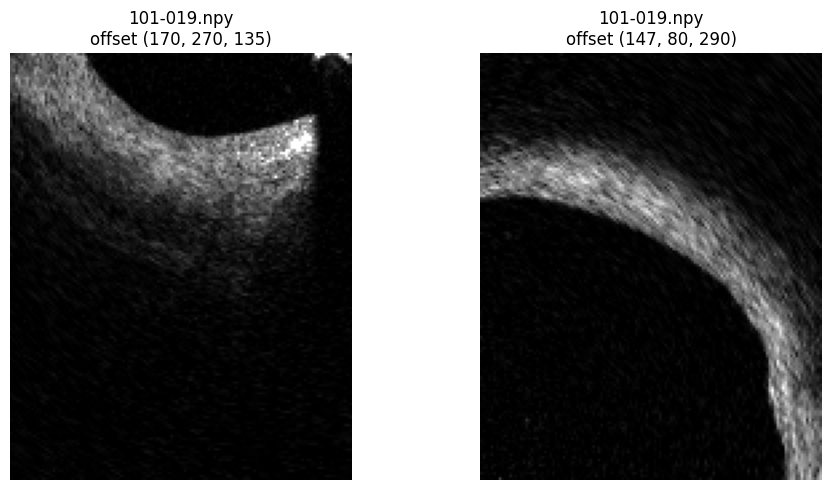

In [15]:
import matplotlib.pyplot as plt
import numpy as np # Needed for reshaping the axes array

# Define the maximum number of columns you want
MAX_COLS = 4 

# 1. Collect all the patch arrays and titles first
patches = []
titles = []
for case_name, offset in PATCH_LIST[2:4]:
    case_file = find_case_file(IMAGES_DIR, case_name)
    arr = load_case_array(case_file)
    arr = ensure_4d_CDHW(arr)
    patch, actual_offset = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)
    
    # We are only taking the middle slice for the display
    slice_to_show = patch[0][DEFAULT_PATCH_SIZE[0] // 2]
    
    patches.append(slice_to_show)
    titles.append(f"{case_name}\noffset {actual_offset}")

# 2. Calculate the optimal grid size
num_images = len(patches)
n_cols = min(num_images, MAX_COLS)
n_rows = (num_images + n_cols - 1) // n_cols # Calculate ceiling division

# 3. Create the figure and the grid of subplots (N rows, MAX_COLS columns)
# Adjust figsize for better visualization (e.g., 5 inches per column/row)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5)) 

# Flatten the axes array to easily iterate over it, regardless of the grid shape
# This is crucial for handling 1-row or 1-column grids correctly
axes = axes.flatten() 

# 4. Iterate through the collected patches and plot them
for i in range(num_images):
    ax = axes[i]
    ax.imshow(patches[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

# 5. Hide any unused subplots (if num_images is not a perfect multiple of n_cols)
for i in range(num_images, len(axes)):
    fig.delaxes(axes[i]) # Removes the empty subplot

# Adjust the layout so titles don't overlap
plt.tight_layout() 
# Display all the plots
plt.show()

In [16]:
# Main pipeline: compute embeddings for PATCH_LIST across PRETRAINED_MODELS and visualize
import matplotlib.patches as patches
from matplotlib import cm

def compute_embeddings_for_models(patch_list, pretrained_models, image_root, patch_size=DEFAULT_PATCH_SIZE, target_module=None):
    """Returns: dict model_path -> dict with keys 'embeddings' (N x C), 'coords' (N x 2 after UMAP), 'patches' (list of patch arrays)
    """
    results = {}
    for m_idx, model in enumerate(pretrained_models):
        pretrained_weights_file, model_name = model
        print(f'Processing model {m_idx+1}/{len(pretrained_models)}: {model}')
        predictor = nnUNetPredictor(tile_step_size=0.5, use_gaussian=True, use_mirroring=False, perform_everything_on_device=True, device=DEVICE)
        # Initialize predictor
        initialize_untrained_predictor(predictor, plans_file)
        if pretrained_weights_file.exists():
            print('Loading pretrained weights from', pretrained_weights_file)
            load_pretrained_weights(predictor.network, pretrained_weights_file)
        embeddings = []
        patches = []
        for case_name, offset in patch_list:
            case_file = find_case_file(image_root, case_name)
            arr = load_case_array(case_file)
            arr = ensure_4d_CDHW(arr)
            patch, actual_offset = extract_patch_from_array(arr, offset, patch_size)
            patches.append(patch)
            x_in = np.expand_dims(patch, 0)  # (1,C,D,H,W)
            t = torch.from_numpy(x_in).float()
            try:
                v = extract_activation_vector(predictor, t, target_module_name=target_module)
            except Exception as e:
                print('Failed to extract activation vector for', case_name, offset, ':', e)
                v = np.zeros(64)  # fallback vector
            embeddings.append(v)
        embeddings = np.stack(embeddings, axis=0)
        # # reduce dimensionality (PCA) to speed up UMAP if necessary
        # if embeddings.shape[1] > 64:
        #     print(embeddings.shape[1], 'dimensions too high, reducing to 64 with PCA before UMAP', embeddings.shape)
        #     p = PCA(n_components=min(64, embeddings.shape[1]))
        #     emb_p = p.fit_transform(embeddings)
        # else:
        #     emb_p = embeddings
        # run UMAP to 2D
        emb_p = embeddings
        reducer = PCA(n_components=2)
        # reducer = umap.UMAP(n_components=2, random_state=0)
        coords = reducer.fit_transform(emb_p)
        results[str(model_name)] = {'embeddings': embeddings, 'coords': coords, 'patches': patches}
        # free GPU memory explicitly
        del predictor
        torch.cuda.empty_cache()
    return results

def plot_results(results, patch_list, figsize=(12,10), mode_viz=None):
    if mode_viz is not None:
        models = [mode_viz]
        print('Only model', models)
    else:
        models = list(results.keys())
    # assign colors per model
    # models = list(results.keys())
    cmap = cm.get_cmap('tab10')
    colors = {m: cmap(i % 10) for i,m in enumerate(models)}
    
    # scatter per model with embedded thumbnails
    fig, ax = plt.subplots(figsize=figsize)
    for m_idx, m in enumerate(models):

        coords = results[m]['coords']
        patches_list = results[m]['patches']

        ax.scatter(coords[:,0], coords[:,1], alpha=0)  # invisible but triggers autoscale

        for i, (x, y) in enumerate(coords):
            # extract middle slice thumbnail
            patch = patches_list[i]
            mid = patch.shape[1] // 2
            thumb = patch[0, mid]
            
            # normalize thumbnail for display
            thumb_norm = (thumb - thumb.min()) / (thumb.max() - thumb.min() + 1e-6)
            
            # create RGB image with colored border
            thumb_rgb = np.stack([thumb_norm]*3, axis=-1)
            border_color = np.array(colors[m][:3])
            
            # add colored border (5 pixels)
            border_width = 5
            h, w = thumb_rgb.shape[:2]
            thumb_bordered = np.ones((h + 2*border_width, w + 2*border_width, 3))
            thumb_bordered[:] = border_color
            thumb_bordered[border_width:-border_width, border_width:-border_width] = thumb_rgb
            
            # embed as annotation
            # imagebox = OffsetImage(thumb_bordered, zoom=0.3, cmap='gray')
            # imagebox = OffsetImage(thumb_bordered, zoom=0.07, cmap='gray')
            imagebox = OffsetImage(thumb_bordered, zoom=0.09, cmap='gray')
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
    
    # add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[m], 
                              markersize=10, label=m) for m in models]
    ax.legend(handles=legend_elements, fontsize=10, loc='upper right')
    
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.set_title('PCA embeddings with patch thumbnails (border color = model)')
    plt.tight_layout()
    plt.show()

In [17]:
# def plot_results(results, patch_list, figsize=(10,8)):
#     # assign colors per model
#     models = list(results.keys())
#     cmap = cm.get_cmap('tab10')
#     colors = {m: cmap(i % 10) for i,m in enumerate(models)}
#     # scatter per model (each has N points)
#     plt.figure(figsize=figsize)
#     for m in models:
#         coords = results[m]['coords']
#         plt.scatter(coords[:,0], coords[:,1], label=m, color=colors[m], s=40)
#         # annotate with patch index to link with thumbnails
#         for i,(x,y) in enumerate(coords):
#             plt.text(x, y, str(i), color='k', fontsize=8)
#     plt.legend(fontsize=8)
#     plt.title('UMAP embeddings (one point per patch)')
#     plt.show()

#     # show thumbnails in a grid and a color bar showing model colors
#     N = len(patch_list)
#     ncols = min(6, N)
#     nrows = int(np.ceil(N / ncols))
#     fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
#     axs = np.atleast_2d(axs).reshape(nrows, ncols)
#     for i, (case_name, offset) in enumerate(patch_list):
#         r = i // ncols
#         c = i % ncols
#         ax = axs[r,c]
#         patch = results[list(results.keys())[0]]['patches'][i]  # pick first model's patch (same patches)
#         # show middle depth slice
#         mid = patch.shape[1] // 2
#         ax.imshow(patch[0, mid], cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'{i}: {case_name} offset={offset}')
#         # draw small color legend squares for each model under the thumbnail
#         for j,m in enumerate(models):
#             col = colors[m]
#             rect = patches.Rectangle((0.02 + 0.08*j, 0.02), 0.06, 0.06, transform=ax.transAxes, facecolor=col, edgecolor='k')
#             ax.add_patch(rect)
#     # hide empty axes
#     for i in range(N, nrows*ncols):
#         r = i // ncols
#         c = i % ncols
#         axs[r,c].axis('off')
#     plt.suptitle('Patch middle-slices with model color keys (squares)')
#     plt.show()

In [18]:
%matplotlib inline


Processing model 1/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth'), 'LaW')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/

/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 2/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt'), 'Genesis')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis

/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 3/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt'), 'CLIP')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt ###################


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 4/4: (PosixPath('None'), 'No Pretrain')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Only model ['LaW']


/tmp/ipykernel_2523950/2235740368.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


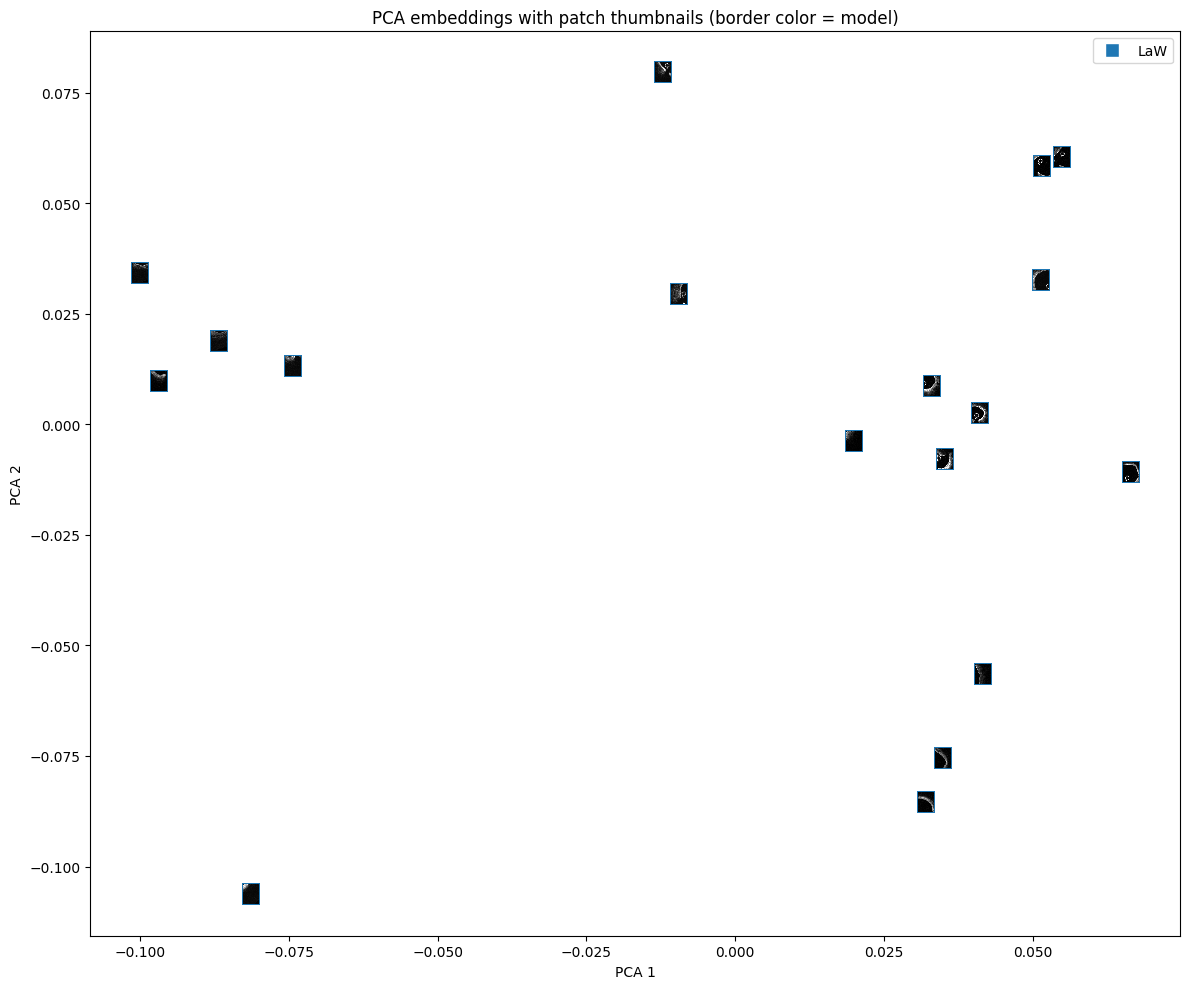

In [19]:
# Example run: user should populate PATCH_LIST and PRETRAINED_MODELS above, then run this cell.
# Example values (uncomment and edit):
# PATCH_LIST = [('101-044_0000.nii.gz', (140,150,128)), ('101-045_0000.nii.gz', (120,130,100))]
# PRETRAINED_MODELS = ['/path/to/modelA', '/path/to/modelB']

if len(PATCH_LIST) == 0:
    print('No patches provided: set PATCH_LIST and rerun the cell')
else:
    results = compute_embeddings_for_models(PATCH_LIST, PRETRAINED_MODELS, IMAGES_DIR, patch_size=DEFAULT_PATCH_SIZE)
    plot_results(results, PATCH_LIST, mode_viz="LaW")

In [20]:
# # Save results to file (optional)
# import pickle
# with open('/home/naravich/umap_full_large_set_patches.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [21]:
# # Load results from file (optional)
# import pickle
# with open('umap_results.pkl', 'rb') as f:
#     results = pickle.load(f)

Only model ['LaW']


/tmp/ipykernel_2523950/2235740368.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


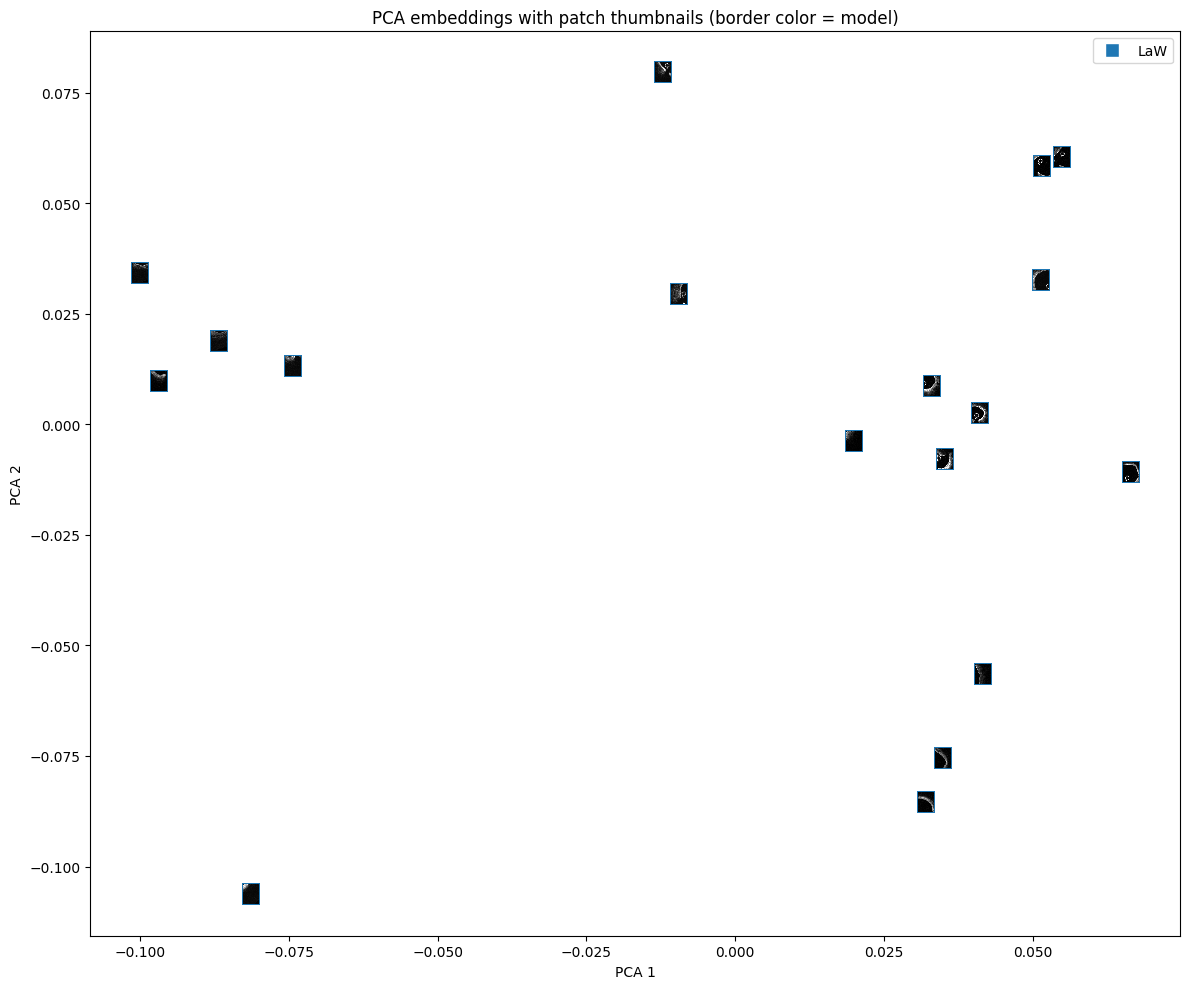

In [22]:
plot_results(results, PATCH_LIST, mode_viz="LaW")


In [23]:
import numpy as np
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import os

for i in range(len(results.keys())):
    model_name = list(results.keys())[i]
    model_data = results[model_name]

    # Use the 2D coordinates for the projection
    embeddings = model_data['embeddings']
    patches = model_data['patches']

    # --- A. Create the Sprite Image ---
    def create_sprite_image(patches, thumbnail_size=64):
        """Combines all patches into a single square sprite image."""
        N = len(patches)
        # Determine the side length of the square grid (N_side x N_side)
        N_side = int(np.ceil(np.sqrt(N)))
        
        # Calculate the total size of the sprite image
        sprite_width = N_side * thumbnail_size
        sprite_height = N_side * thumbnail_size
        
        sprite = Image.new('L', (sprite_width, sprite_height)) # 'L' for grayscale
        
        for i, patch in enumerate(patches):
            # Extract the middle slice as the thumbnail (as done in plot_results)
            mid = patch.shape[1] // 2
            thumb = patch[0, mid] # shape (H, W)
            
            # Normalize and convert to 8-bit image
            thumb_norm = ((thumb - thumb.min()) / (thumb.max() - thumb.min() + 1e-6) * 255).astype(np.uint8)
            
            # Resize the thumbnail (optional, but good for standardization)
            img = Image.fromarray(thumb_norm).resize((thumbnail_size, thumbnail_size))
            
            # Calculate position in the sprite grid
            row = i // N_side
            col = i % N_side
            x = col * thumbnail_size
            y = row * thumbnail_size
            
            sprite.paste(img, (x, y))
            
        return sprite

    # Create the log directory
    log_dir = f'/home/naravich/runs/embedding_projector/{model_name}'
    os.makedirs(log_dir, exist_ok=True)

    # 1. Generate and save the sprite image
    sprite_image = create_sprite_image(patches, 256)
    sprite_path = os.path.join(log_dir, 'sprite.png')
    sprite_image.save(sprite_path)
    print(f"Sprite image saved to: {sprite_path}")

    # 2. Prepare metadata (optional, but highly recommended)
    # This creates a file with one label/name per data point
    metadata_path = os.path.join(log_dir, 'metadata.tsv')
    with open(metadata_path, 'w') as f:
        f.write("Case_ID\tPatch_Offset\n")
        for case_name, offset in PATCH_LIST:
            f.write(f"{case_name}\t{offset}\n")
    print(f"Metadata saved to: {metadata_path}")


    # 3. Extract individual thumbnails and prepare a FLOAT N C H W Tensor for label_img
    thumbnail_size = 256
    label_images_float = [] # Renamed for clarity: we want floats here!

    for patch in patches:
        mid = patch.shape[1] // 2
        thumb = patch[0, mid] # Raw patch data
        
        # 1. Normalize to [0.0, 1.0] (FLOAT)
        # This is the cleanest input format for PyTorch/TensorBoard image tensors.
        thumb_float = (thumb - thumb.min()) / (thumb.max() - thumb.min() + 1e-6)
        
        # 2. Convert to PIL image and resize
        # We create a temporary PIL image for the resize operation. 
        # PIL expects 0-255 for uint8, so we scale it up temporarily for the PIL call.
        img = Image.fromarray((thumb_float * 255.0).astype(np.uint8)).resize((thumbnail_size, thumbnail_size))
        
        # 3. Convert back to a float NumPy array and normalize to [0.0, 1.0]
        # We divide by 255.0 to return it to the standard float tensor range.
        label_images_float.append(np.array(img).astype(np.float32) / 255.0)

    # Stack the list of (H, W) images into a single (N, H, W) array
    label_img_array = np.stack(label_images_float, axis=0) # Shape is (N, H, W), values are floats 0.0-1.0

    # 4. Reshape for PyTorch: (N, 1, H, W)
    label_img_reshaped = np.expand_dims(label_img_array, axis=1) # Shape (N, 1, H, W)

    # 5. Convert to PyTorch Tensor
    label_img_tensor = torch.from_numpy(label_img_reshaped)

    # 4. Log the embeddings using SummaryWriter
    writer = SummaryWriter(log_dir)
    # 'tag' is the name that appears in the projector
    writer.add_embedding(
        mat=embeddings, # Use the original high-dimensional embeddings
        metadata=np.array([f"{case_name}_{offset}" for case_name, offset in PATCH_LIST]), # Use the list of names/labels
        label_img=label_img_tensor,
        tag=f'PCA_Projection_of_{model_name}',
    )
    writer.close()

Sprite image saved to: /home/naravich/runs/embedding_projector/LaW/sprite.png
Metadata saved to: /home/naravich/runs/embedding_projector/LaW/metadata.tsv


Sprite image saved to: /home/naravich/runs/embedding_projector/Genesis/sprite.png
Metadata saved to: /home/naravich/runs/embedding_projector/Genesis/metadata.tsv
Sprite image saved to: /home/naravich/runs/embedding_projector/CLIP/sprite.png
Metadata saved to: /home/naravich/runs/embedding_projector/CLIP/metadata.tsv
Sprite image saved to: /home/naravich/runs/embedding_projector/No Pretrain/sprite.png
Metadata saved to: /home/naravich/runs/embedding_projector/No Pretrain/metadata.tsv


In [24]:
# Texture Enhancement/Reduction Functions with Advanced Options

def enhance_reduce_texture(patch, enhancement_factor=1.5, mode='enhance', method='unsharp', 
                          sigma=None, preserve_range=True, adaptive=False):
    """
    Enhance or reduce texture (high-frequency features) in a 3D patch.
    
    Args:
        patch: numpy array of shape (C, D, H, W) where C is channels
        enhancement_factor: float > 1 to enhance, 0 < factor < 1 to reduce
        mode: 'enhance' or 'reduce'
        method: 'unsharp' (recommended) or 'fft_bandpass'
        sigma: Gaussian blur sigma for unsharp method. Auto-scales with patch size if None
        preserve_range: If True, clips output to original intensity range
        adaptive: If True, apply enhancement only where intensity changes significantly
        
    Returns:
        modified_patch: numpy array with same shape as input
    """
    from scipy.ndimage import gaussian_filter
    
    # Work with first channel (C=0) for simplicity
    if patch.ndim == 4:
        patch_data = patch[0].copy()
    else:
        patch_data = patch.copy()
    
    # Auto-scale sigma based on patch size
    if sigma is None:
        avg_dim = np.mean(patch_data.shape)
        sigma = max(1.0, avg_dim / 80.0)
    
    # Store original range for clipping
    orig_min, orig_max = patch_data.min(), patch_data.max()
    orig_range = orig_max - orig_min + 1e-6
    
    if method == 'unsharp':
        # Unsharp Masking: captures fine textures and details naturally
        patch_float = patch_data.astype(np.float32)
        blurred = gaussian_filter(patch_float, sigma=sigma)
        high_pass = patch_float - blurred
        
        # Adaptive masking: only enhance where there's contrast
        if adaptive:
            local_std = gaussian_filter((high_pass ** 2), sigma=sigma) ** 0.5
            adaptive_mask = local_std / (local_std.max() + 1e-6)
            high_pass = high_pass * adaptive_mask
        
        # Apply unsharp mask
        if mode == 'enhance':
            modified = patch_float + (enhancement_factor - 1.0) * high_pass
        elif mode == 'reduce':
            factor = 1.0 / (enhancement_factor + 1e-6)
            modified = patch_float + (factor - 1.0) * high_pass
        else:
            raise ValueError(f"Unknown mode: {mode}")
    
    elif method == 'fft_bandpass':
        # FFT-based band-pass filtering with Gaussian window
        fft_patch = np.fft.fftn(patch_data)
        fft_shifted = np.fft.fftshift(fft_patch)
        magnitude = np.abs(fft_shifted)
        phase = np.angle(fft_shifted)
        
        D, H, W = patch_data.shape
        d_center, h_center, w_center = D // 2, H // 2, W // 2
        
        # Create distance matrix from center
        d_idx = np.arange(D)
        h_idx = np.arange(H)
        w_idx = np.arange(W)
        dd, hh, ww = np.meshgrid(d_idx - d_center, h_idx - h_center, w_idx - w_center, indexing='ij')
        distance = np.sqrt(dd**2 + hh**2 + ww**2)
        
        max_distance = np.sqrt(d_center**2 + h_center**2 + w_center**2)
        normalized_distance = distance / (max_distance + 1e-6)
        
        # Smoother Gaussian band-pass filter
        band_pass = np.exp(-((normalized_distance - 0.3) ** 2) / (2 * 0.2 ** 2))
        band_pass = np.clip(band_pass, 0, 1)
        
        if mode == 'enhance':
            modified_magnitude = magnitude * (1 + band_pass * (enhancement_factor - 1))
        elif mode == 'reduce':
            factor = 1.0 / (enhancement_factor + 1e-6)
            modified_magnitude = magnitude * (1 + band_pass * (factor - 1))
        else:
            raise ValueError(f"Unknown mode: {mode}")
        
        # Reconstruct
        modified_fft_shifted = modified_magnitude * np.exp(1j * phase)
        modified_fft = np.fft.ifftshift(modified_fft_shifted)
        modified = np.real(np.fft.ifftn(modified_fft))
    
    else:
        raise ValueError(f"Unknown method: {method}. Choose 'unsharp' or 'fft_bandpass'")
    
    # Preserve original range
    if preserve_range:
        modified = np.clip(modified, orig_min, orig_max)
    
    # Reconstruct full patch with channels
    if patch.ndim == 4:
        modified_patch = patch.copy().astype(np.float32)
        modified_patch[0] = modified
        return modified_patch
    else:
        return modified


def enhance_multiscale_texture(patch, enhancement_factor=1.5, mode='enhance', scales=None):
    """
    Multi-scale texture enhancement: apply enhancement at multiple scales and combine.
    Better for capturing details at different sizes.
    
    Args:
        patch: numpy array of shape (C, D, H, W)
        enhancement_factor: amplification strength
        mode: 'enhance' or 'reduce'
        scales: list of sigma values (auto-generated if None)
        
    Returns:
        enhanced_patch: combined multi-scale enhancement
    """
    if patch.ndim == 4:
        patch_data = patch[0].copy()
    else:
        patch_data = patch.copy()
    
    if scales is None:
        # Default scales: fine, medium, coarse
        avg_dim = np.mean(patch_data.shape)
        scales = [avg_dim / 120.0, avg_dim / 60.0, avg_dim / 30.0]
    
    # Enhance at each scale
    enhanced_scales = []
    for sigma in scales:
        enhanced = enhance_reduce_texture(
            patch, 
            enhancement_factor=enhancement_factor, 
            mode=mode, 
            method='unsharp',
            sigma=sigma,
            adaptive=False
        )
        enhanced_scales.append(enhanced[0] if enhanced.ndim == 4 else enhanced)
    
    # Combine scales with equal weighting
    combined = np.mean(enhanced_scales, axis=0)
    
    if patch.ndim == 4:
        result = patch.copy().astype(np.float32)
        result[0] = combined
        return result
    else:
        return combined


def adjust_intensity(patch, intensity_factor=1.2):
    """
    Adjust the intensity (brightness) of a patch.
    
    Args:
        patch: numpy array of shape (C, D, H, W) or (D, H, W)
        intensity_factor: float > 1 to brighten, 0 < factor < 1 to darken
        
    Returns:
        modified_patch: numpy array with same shape as input
    """
    # Normalize, apply factor, then rescale
    original_min = patch.min()
    original_max = patch.max()
    original_range = original_max - original_min + 1e-6
    
    normalized = (patch - original_min) / original_range
    brightened = normalized * intensity_factor
    brightened = np.clip(brightened, 0, 1.0)
    modified_patch = brightened * original_range + original_min
    
    return modified_patch

In [25]:
# Texture Quantification - High-Frequency Energy Focus

def compute_high_frequency_score(patch):
    """
    Compute high-frequency energy score (0-100) for a 3D patch.
    Simple, interpretable metric for texture richness.
    
    Args:
        patch: numpy array of shape (C, D, H, W) or (D, H, W)
        
    Returns:
        dict with:
            - high_freq_score: Energy in high frequencies (0-100)
            - high_freq_energy: Raw energy value
            - total_energy: Total energy in FFT
            - high_freq_ratio: Ratio of high-freq to total
    """
    # Extract 3D data
    if patch.ndim == 4:
        data = patch[0]
    else:
        data = patch
    
    data = data.astype(np.float32)
    
    # FFT analysis
    fft_data = np.fft.fftn(data)
    fft_shifted = np.fft.fftshift(fft_data)
    magnitude = np.abs(fft_shifted)
    
    D, H, W = data.shape
    d_center, h_center, w_center = D // 2, H // 2, W // 2
    
    # Distance from center
    d_idx = np.arange(D)
    h_idx = np.arange(H)
    w_idx = np.arange(W)
    dd, hh, ww = np.meshgrid(d_idx - d_center, h_idx - h_center, w_idx - w_center, indexing='ij')
    distance = np.sqrt(dd**2 + hh**2 + ww**2)
    
    max_distance = np.sqrt(d_center**2 + h_center**2 + w_center**2)
    normalized_distance = distance / (max_distance + 1e-6)
    
    # High frequencies: 30-100% of spectrum (middle to outer)
    high_freq_mask = (normalized_distance > 0.3) & (normalized_distance < 1.0)
    high_freq_energy = np.sum(magnitude[high_freq_mask] ** 2)
    
    total_energy = np.sum(magnitude ** 2)
    high_freq_ratio = high_freq_energy / (total_energy + 1e-6)
    
    # Normalize to 0-100 scale
    high_freq_score = high_freq_ratio * 100.0
    
    return {
        'high_freq_score': float(high_freq_score),
        'high_freq_energy': float(high_freq_energy),
        'total_energy': float(total_energy),
        'high_freq_ratio': float(high_freq_ratio)
    }


def analyze_patch_texture(patch):
    """Get high-frequency score for a patch."""
    return compute_high_frequency_score(patch)


def compare_high_frequency_across_patches(patch_list, image_root, patch_size):
    """
    Compute high-frequency scores for all patches.
    
    Returns:
        list of dicts with scores and patch info
    """
    results = []
    for case_name, offset in patch_list:
        case_file = find_case_file(image_root, case_name)
        arr = load_case_array(case_file)
        arr = ensure_4d_CDHW(arr)
        patch, _ = extract_patch_from_array(arr, offset, patch_size)
        
        metrics = compute_high_frequency_score(patch)
        metrics['case_name'] = case_name
        metrics['offset'] = offset
        results.append(metrics)
    
    return results

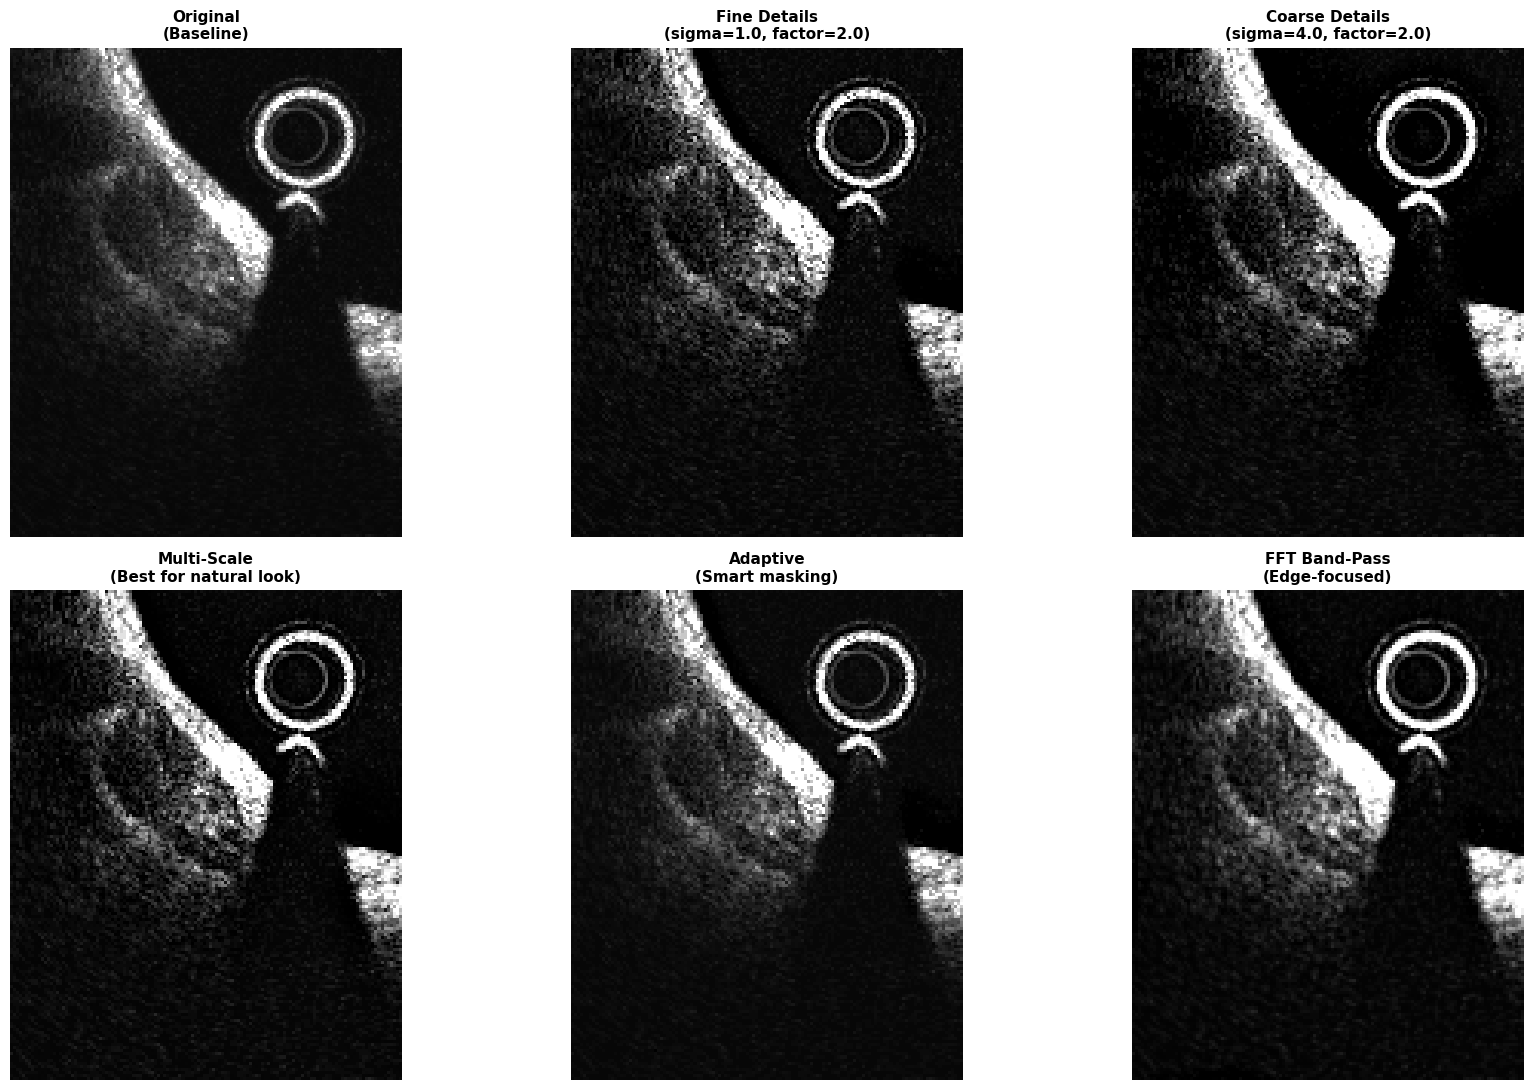

Enhancement Statistics:
Original range: [-0.5507, 9.5017]
Fine detail range: [-0.5507, 9.5017]
Multi-scale range: [-0.5507, 9.5017]
Adaptive range: [-0.5507, 9.5017]

✓ All ranges preserved within original bounds (preserve_range=True)

Best practices:
  • Fine details (sigma=1-2): Micro-textures, noise-sensitive
  • Coarse details (sigma=3-5): Edges, structural features
  • Multi-scale: Balanced enhancement across all scales (recommended)
  • Adaptive: Avoids over-enhancement in uniform regions


In [26]:
# Visualization: Texture Enhancement with Improvements

# Example: Take a patch from PATCH_LIST and visualize different enhancement strategies
if len(PATCH_LIST) > 0:
    # Load an example patch
    case_name, offset = PATCH_LIST[0]
    case_file = find_case_file(IMAGES_DIR, case_name)
    arr = load_case_array(case_file)
    arr = ensure_4d_CDHW(arr)
    example_patch, _ = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)
    
    # Get middle slice for visualization
    mid_slice_idx = DEFAULT_PATCH_SIZE[0] // 2
    original_slice = example_patch[0, mid_slice_idx]
    
    # Different enhancement strategies
    # 1. Unsharp masking with fine detail (small sigma)
    enhanced_fine = enhance_reduce_texture(example_patch, enhancement_factor=2.0, mode='enhance', 
                                           method='unsharp', sigma=1.0)
    
    # 2. Unsharp masking with coarse detail (large sigma)
    enhanced_coarse = enhance_reduce_texture(example_patch, enhancement_factor=2.0, mode='enhance', 
                                             method='unsharp', sigma=4.0)
    
    # 3. Multi-scale enhancement (combines multiple scales)
    enhanced_multiscale = enhance_multiscale_texture(example_patch, enhancement_factor=2.0, mode='enhance')
    
    # 4. Adaptive enhancement (only enhances where there's contrast)
    enhanced_adaptive = enhance_reduce_texture(example_patch, enhancement_factor=2.0, mode='enhance',
                                               method='unsharp', adaptive=True)
    
    # Extract slices
    enhanced_fine_slice = enhanced_fine[0, mid_slice_idx]
    enhanced_coarse_slice = enhanced_coarse[0, mid_slice_idx]
    enhanced_multiscale_slice = enhanced_multiscale[0, mid_slice_idx]
    enhanced_adaptive_slice = enhanced_adaptive[0, mid_slice_idx]
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    
    # Original
    axes[0, 0].imshow(original_slice, cmap='gray')
    axes[0, 0].set_title('Original\n(Baseline)', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Fine detail enhancement
    axes[0, 1].imshow(enhanced_fine_slice, cmap='gray')
    axes[0, 1].set_title('Fine Details\n(sigma=1.0, factor=2.0)', fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Coarse detail enhancement
    axes[0, 2].imshow(enhanced_coarse_slice, cmap='gray')
    axes[0, 2].set_title('Coarse Details\n(sigma=4.0, factor=2.0)', fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Multi-scale enhancement
    axes[1, 0].imshow(enhanced_multiscale_slice, cmap='gray')
    axes[1, 0].set_title('Multi-Scale\n(Best for natural look)', fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Adaptive enhancement
    axes[1, 1].imshow(enhanced_adaptive_slice, cmap='gray')
    axes[1, 1].set_title('Adaptive\n(Smart masking)', fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')
    
    # FFT Band-pass for comparison
    enhanced_fft = enhance_reduce_texture(example_patch, enhancement_factor=2.0, mode='enhance', 
                                          method='fft_bandpass')
    enhanced_fft_slice = enhanced_fft[0, mid_slice_idx]
    axes[1, 2].imshow(enhanced_fft_slice, cmap='gray')
    axes[1, 2].set_title('FFT Band-Pass\n(Edge-focused)', fontsize=11, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("Enhancement Statistics:")
    print(f"Original range: [{original_slice.min():.4f}, {original_slice.max():.4f}]")
    print(f"Fine detail range: [{enhanced_fine_slice.min():.4f}, {enhanced_fine_slice.max():.4f}]")
    print(f"Multi-scale range: [{enhanced_multiscale_slice.min():.4f}, {enhanced_multiscale_slice.max():.4f}]")
    print(f"Adaptive range: [{enhanced_adaptive_slice.min():.4f}, {enhanced_adaptive_slice.max():.4f}]")
    print("\n✓ All ranges preserved within original bounds (preserve_range=True)")
    print("\nBest practices:")
    print("  • Fine details (sigma=1-2): Micro-textures, noise-sensitive")
    print("  • Coarse details (sigma=3-5): Edges, structural features")
    print("  • Multi-scale: Balanced enhancement across all scales (recommended)")
    print("  • Adaptive: Avoids over-enhancement in uniform regions")

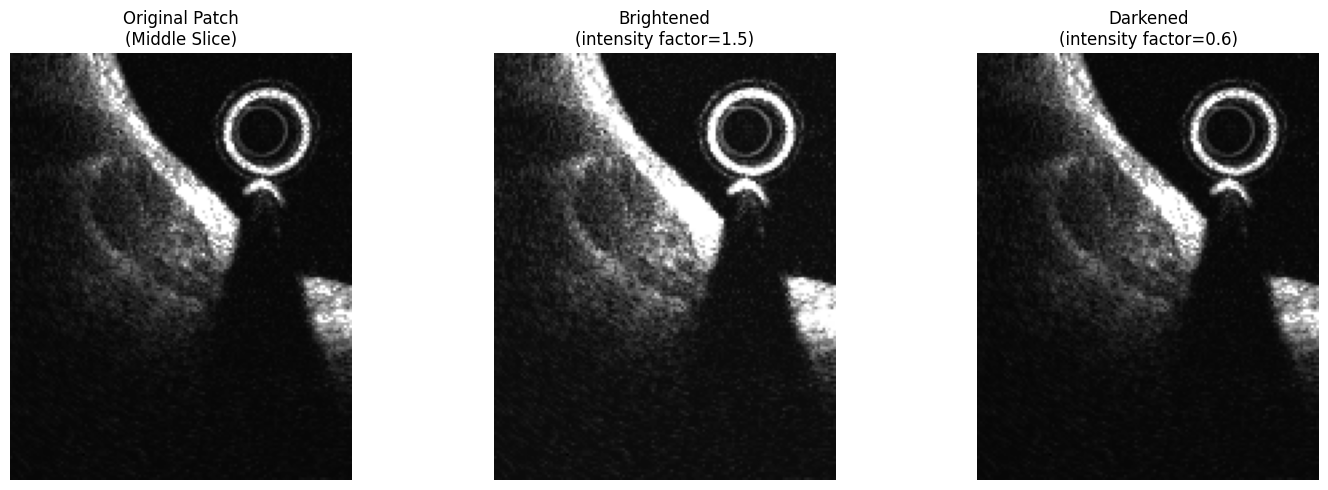

Original patch range: [-0.5507, 9.5017]
Brightened patch range: [-0.5507, 9.5018]
Darkened patch range: [-0.5507, 5.4808]


In [27]:
# Visualization: Intensity Adjustment (Brightness)

# Example: Take the same patch and visualize intensity modification
if len(PATCH_LIST) > 0:
    # Use the same example patch from above
    mid_slice_idx = DEFAULT_PATCH_SIZE[0] // 2
    original_slice = example_patch[0, mid_slice_idx]
    
    # Apply intensity adjustment (brightening and darkening)
    brightened_patch = adjust_intensity(example_patch, intensity_factor=1.5)
    darkened_patch = adjust_intensity(example_patch, intensity_factor=0.6)
    
    brightened_slice = brightened_patch[0, mid_slice_idx]
    darkened_slice = darkened_patch[0, mid_slice_idx]
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_slice, cmap='gray')
    axes[0].set_title('Original Patch\n(Middle Slice)')
    axes[0].axis('off')
    
    axes[1].imshow(brightened_slice, cmap='gray')
    axes[1].set_title('Brightened\n(intensity factor=1.5)')
    axes[1].axis('off')
    
    axes[2].imshow(darkened_slice, cmap='gray')
    axes[2].set_title('Darkened\n(intensity factor=0.6)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original patch range: [{original_slice.min():.4f}, {original_slice.max():.4f}]")
    print(f"Brightened patch range: [{brightened_slice.min():.4f}, {brightened_slice.max():.4f}]")
    print(f"Darkened patch range: [{darkened_slice.min():.4f}, {darkened_slice.max():.4f}]")


Computing high-frequency scores for all patches...


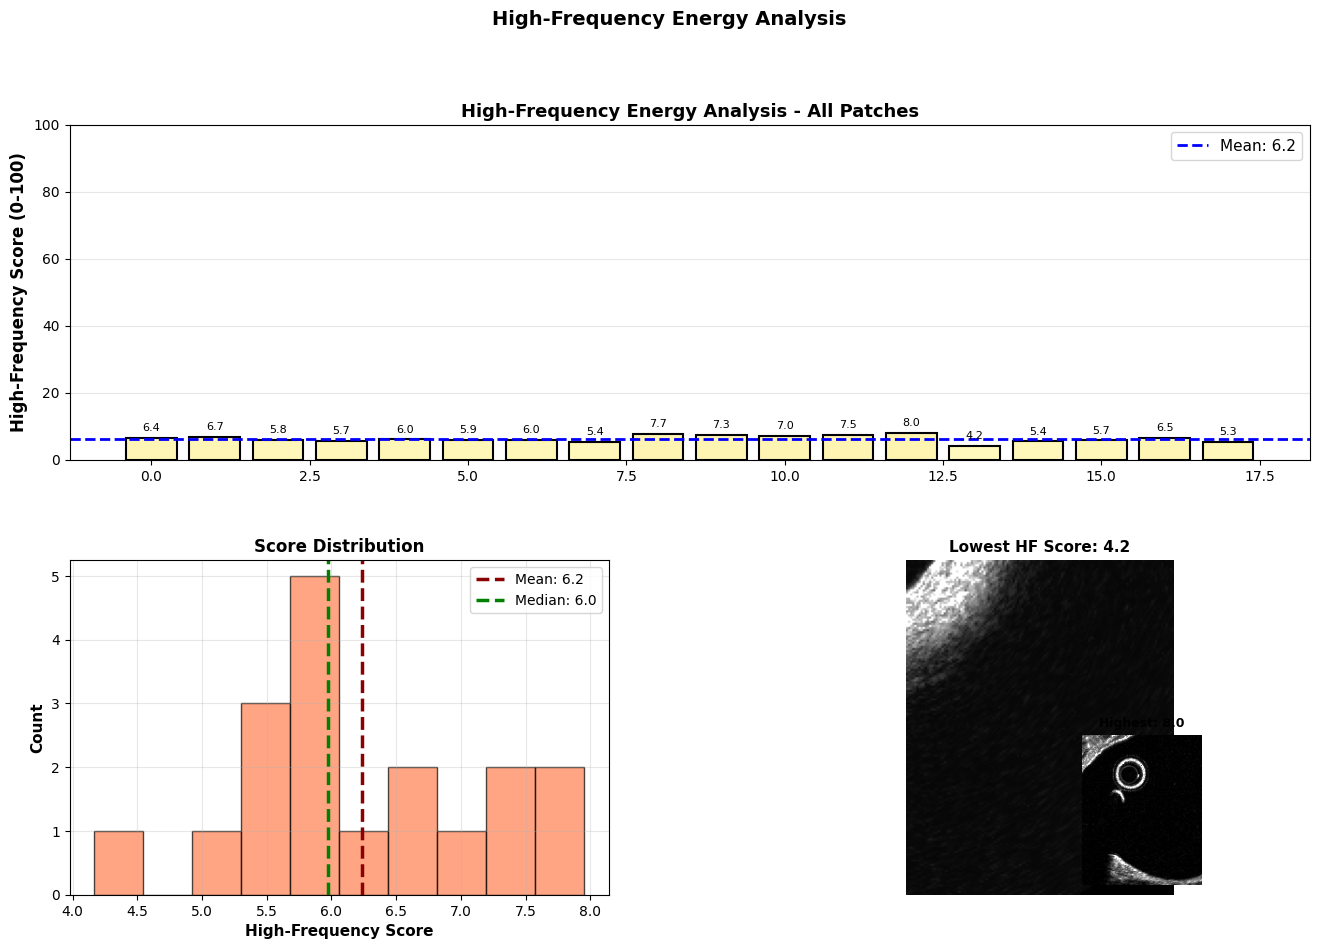


HIGH-FREQUENCY SCORE STATISTICS
Min:    4.17
Max:    7.95
Mean:   6.24
Median: 5.97
Std:    0.96


In [28]:
# Visualization: High-Frequency Analysis Across Patches

if len(PATCH_LIST) > 0:
    print("Computing high-frequency scores for all patches...")
    hf_results = compare_high_frequency_across_patches(PATCH_LIST, IMAGES_DIR, DEFAULT_PATCH_SIZE)
    
    # Extract scores
    hf_scores = [r['high_freq_score'] for r in hf_results]
    case_labels = [f"{r['case_name'][:8]}\n{r['offset']}" for r in hf_results]
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. High-Frequency Score Bar Chart
    ax1 = fig.add_subplot(gs[0, :])
    colors_bar = plt.cm.YlOrRd(np.array(hf_scores) / 100.0)
    bars = ax1.bar(range(len(hf_scores)), hf_scores, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax1.axhline(y=np.mean(hf_scores), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(hf_scores):.1f}')
    ax1.set_ylabel('High-Frequency Score (0-100)', fontsize=12, fontweight='bold')
    ax1.set_title('High-Frequency Energy Analysis - All Patches', fontsize=13, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, hf_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
                f'{score:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(hf_scores, bins=10, color='coral', edgecolor='black', alpha=0.7)
    ax2.axvline(np.mean(hf_scores), color='darkred', linestyle='--', linewidth=2.5, 
                label=f'Mean: {np.mean(hf_scores):.1f}')
    ax2.axvline(np.median(hf_scores), color='green', linestyle='--', linewidth=2.5, 
                label=f'Median: {np.median(hf_scores):.1f}')
    ax2.set_xlabel('High-Frequency Score', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax2.set_title('Score Distribution', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)
    
    # 3. Lowest vs Highest example patches
    min_idx = np.argmin(hf_scores)
    max_idx = np.argmax(hf_scores)
    
    # Lowest
    ax3 = fig.add_subplot(gs[1, 1])
    case_name, offset = PATCH_LIST[min_idx]
    case_file = find_case_file(IMAGES_DIR, case_name)
    arr = load_case_array(case_file)
    arr = ensure_4d_CDHW(arr)
    patch_low, _ = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)
    mid_slice = DEFAULT_PATCH_SIZE[0] // 2
    ax3.imshow(patch_low[0, mid_slice], cmap='gray')
    ax3.set_title(f'Lowest HF Score: {hf_scores[min_idx]:.1f}', fontsize=11, fontweight='bold')
    ax3.axis('off')
    
    # Create small inset for highest
    ax4 = fig.add_axes([0.72, 0.12, 0.15, 0.15])
    case_name, offset = PATCH_LIST[max_idx]
    case_file = find_case_file(IMAGES_DIR, case_name)
    arr = load_case_array(case_file)
    arr = ensure_4d_CDHW(arr)
    patch_high, _ = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)
    ax4.imshow(patch_high[0, mid_slice], cmap='gray')
    ax4.set_title(f'Highest: {hf_scores[max_idx]:.1f}', fontsize=9, fontweight='bold')
    ax4.axis('off')
    
    plt.suptitle('High-Frequency Energy Analysis', fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    # Statistics
    print("\n" + "="*60)
    print("HIGH-FREQUENCY SCORE STATISTICS")
    print("="*60)
    print(f"Min:    {min(hf_scores):.2f}")
    print(f"Max:    {max(hf_scores):.2f}")
    print(f"Mean:   {np.mean(hf_scores):.2f}")
    print(f"Median: {np.median(hf_scores):.2f}")
    print(f"Std:    {np.std(hf_scores):.2f}")
    print("="*60)


SANITY CHECK: Texture Manipulation & HF Score Verification

Using example patch from PATCH_LIST[0]

1. ORIGINAL PATCH
   HF Score: 6.39
   HF Energy: 1.19e+11

2. ENHANCED TEXTURE (factor=2.0)
   HF Score: 12.61
   HF Energy: 2.94e+11
   ✓ Change: +6.22 (EXPECTED ↑)

3. REDUCED TEXTURE (factor=2.0)
   HF Score: 2.33
   HF Energy: 3.47e+10
   ✓ Change: -4.06 (EXPECTED ↓)


/tmp/ipykernel_2523950/1273787544.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


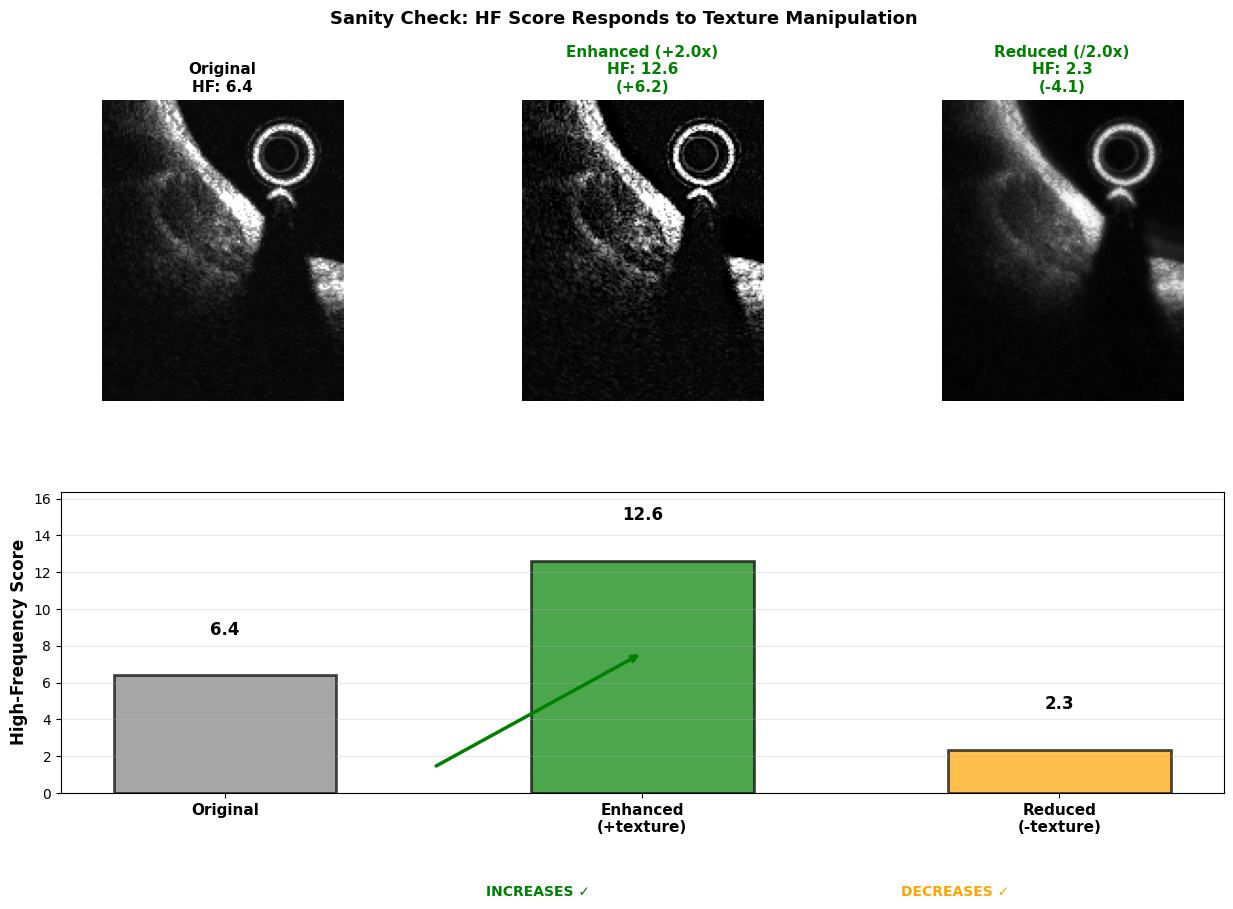


VALIDATION RESULTS
✓ Enhancement increases HF score: +6.22
✓ Reduction decreases HF score: -4.06

✓✓ SANITY CHECK PASSED - Metrics behave as expected!


In [29]:
# Sanity Check: Enhancement/Reduction Should Change HF Score

if len(PATCH_LIST) > 0:
    print("\n" + "="*70)
    print("SANITY CHECK: Texture Manipulation & HF Score Verification")
    print("="*70)
    print(f"\nUsing example patch from PATCH_LIST[0]")
    # Load an example patch
    case_name, offset = PATCH_LIST[0]
    case_file = find_case_file(IMAGES_DIR, case_name)
    arr = load_case_array(case_file)
    arr = ensure_4d_CDHW(arr)
    example_patch, _ = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)
    # Use the same example_patch from the enhancement visualization
    test_patch = example_patch
    mid_idx = DEFAULT_PATCH_SIZE[0] // 2
    
    # Original metrics
    orig_metrics = compute_high_frequency_score(test_patch)
    print(f"\n1. ORIGINAL PATCH")
    print(f"   HF Score: {orig_metrics['high_freq_score']:.2f}")
    print(f"   HF Energy: {orig_metrics['high_freq_energy']:.2e}")
    
    # Enhanced texture (should INCREASE HF score)
    enhanced_patch = enhance_reduce_texture(test_patch, enhancement_factor=2.0, 
                                           mode='enhance', method='unsharp')
    enhanced_metrics = compute_high_frequency_score(enhanced_patch)
    print(f"\n2. ENHANCED TEXTURE (factor=2.0)")
    print(f"   HF Score: {enhanced_metrics['high_freq_score']:.2f}")
    print(f"   HF Energy: {enhanced_metrics['high_freq_energy']:.2e}")
    change_enhanced = enhanced_metrics['high_freq_score'] - orig_metrics['high_freq_score']
    print(f"   ✓ Change: {change_enhanced:+.2f} {'(EXPECTED ↑)' if change_enhanced > 0 else '(UNEXPECTED ↓)'}")
    
    # Reduced texture (should DECREASE HF score)
    reduced_patch = enhance_reduce_texture(test_patch, enhancement_factor=2.0, 
                                          mode='reduce', method='unsharp')
    reduced_metrics = compute_high_frequency_score(reduced_patch)
    print(f"\n3. REDUCED TEXTURE (factor=2.0)")
    print(f"   HF Score: {reduced_metrics['high_freq_score']:.2f}")
    print(f"   HF Energy: {reduced_metrics['high_freq_energy']:.2e}")
    change_reduced = reduced_metrics['high_freq_score'] - orig_metrics['high_freq_score']
    print(f"   ✓ Change: {change_reduced:+.2f} {'(EXPECTED ↓)' if change_reduced < 0 else '(UNEXPECTED ↑)'}")
    
    # Visualization
    fig = plt.figure(figsize=(15, 9))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Row 1: Images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(test_patch[0, mid_idx], cmap='gray')
    ax1.set_title(f'Original\nHF: {orig_metrics["high_freq_score"]:.1f}', 
                         fontsize=11, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(enhanced_patch[0, mid_idx], cmap='gray')
    ax2.set_title(f'Enhanced (+2.0x)\nHF: {enhanced_metrics["high_freq_score"]:.1f}\n({change_enhanced:+.1f})', 
                         fontsize=11, fontweight='bold', 
                         color='green' if change_enhanced > 0 else 'red')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(reduced_patch[0, mid_idx], cmap='gray')
    ax3.set_title(f'Reduced (/2.0x)\nHF: {reduced_metrics["high_freq_score"]:.1f}\n({change_reduced:+.1f})', 
                         fontsize=11, fontweight='bold',
                         color='green' if change_reduced < 0 else 'red')
    ax3.axis('off')
    
    # Row 2: Bar chart comparison (spanning all 3 columns)
    ax = fig.add_subplot(gs[1, :])
    x_pos = np.array([0, 1.5, 3])
    scores = [orig_metrics['high_freq_score'], 
              enhanced_metrics['high_freq_score'], 
              reduced_metrics['high_freq_score']]
    colors = ['gray', 'green', 'orange']
    bars = ax.bar(x_pos, scores, width=0.8, color=colors, edgecolor='black', linewidth=2, alpha=0.7)
    
    # Add value labels and arrows
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax.text(bar.get_x() + bar.get_width()/2, score + 2, f'{score:.1f}', 
               ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add arrow annotations
    ax.annotate('', xy=(1.5, enhanced_metrics['high_freq_score'] - 5), 
               xytext=(0.75, orig_metrics['high_freq_score'] - 5),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='green'))
    ax.text(1.125, orig_metrics['high_freq_score'] - 12, 'INCREASES ✓', 
           ha='center', fontsize=10, fontweight='bold', color='green')
    
    ax.annotate('', xy=(3, reduced_metrics['high_freq_score'] - 5), 
               xytext=(2.25, orig_metrics['high_freq_score'] - 5),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='orange'))
    ax.text(2.625, orig_metrics['high_freq_score'] - 12, 'DECREASES ✓', 
           ha='center', fontsize=10, fontweight='bold', color='orange')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Original', 'Enhanced\n(+texture)', 'Reduced\n(-texture)'], fontsize=11, fontweight='bold')
    ax.set_ylabel('High-Frequency Score', fontsize=12, fontweight='bold')
    ax.set_ylim(0, max(scores) * 1.3)
    ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Sanity Check: HF Score Responds to Texture Manipulation', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Validation check
    print(f"\n" + "="*70)
    print("VALIDATION RESULTS")
    print("="*70)
    if change_enhanced > 0:
        print(f"✓ Enhancement increases HF score: {change_enhanced:+.2f}")
    else:
        print(f"✗ WARNING: Enhancement did not increase HF score")
    
    if change_reduced < 0:
        print(f"✓ Reduction decreases HF score: {change_reduced:+.2f}")
    else:
        print(f"✗ WARNING: Reduction did not decrease HF score")
    
    if change_enhanced > 0 and change_reduced < 0:
        print(f"\n✓✓ SANITY CHECK PASSED - Metrics behave as expected!")
    print("="*70)

# Texture Modification Impact on Embeddings

This section explores how texture enhancement/reduction at different intensities affects the embedding space for a single patch across different pretrained models.

In [30]:
def create_texture_modified_patches(patch, enhancement_factors=None):
    """
    Create multiple texture-modified versions of a single patch.
    
    Args:
        patch: Original patch array (C, D, H, W)
        enhancement_factors: List of factors to apply. Default includes reduction and enhancement.
                           Factors < 1.0 = reduce texture, > 1.0 = enhance texture
    
    Returns:
        dict with keys:
            'patches': list of modified patch arrays
            'factors': list of factors used
            'labels': list of descriptive labels
    """
    if enhancement_factors is None:
        # Default: range from strong reduction to strong enhancement
        enhancement_factors = [0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 2.0]
    
    modified_patches = []
    labels = []
    
    for factor in enhancement_factors:
        if factor < 1.0:
            # Reduce texture
            mode = 'reduce'
            actual_factor = 1.0 / factor  # Convert to reduction factor
            label = f'Reduce {factor:.2f}x'
        elif factor == 1.0:
            # Original (no modification)
            modified_patches.append(patch.copy())
            labels.append('Original')
            continue
        else:
            # Enhance texture
            mode = 'enhance'
            actual_factor = factor
            label = f'Enhance {factor:.2f}x'
        
        modified = enhance_reduce_texture(
            patch,
            enhancement_factor=actual_factor,
            mode=mode,
            method='unsharp',
            adaptive=False
        )
        modified_patches.append(modified)
        labels.append(label)
    
    return {
        'patches': modified_patches,
        'factors': enhancement_factors,
        'labels': labels
    }


def compute_embeddings_for_texture_variants(patch, patch_info, pretrained_models, patch_size=DEFAULT_PATCH_SIZE, 
                                           target_module=None, enhancement_factors=None):
    """
    Compute embeddings for texture-modified variants of a single patch across multiple models.
    
    Args:
        patch: Original patch array (C, D, H, W)
        patch_info: Tuple (case_name, offset) for identification
        pretrained_models: List of (model_path, model_name) tuples
        patch_size: Size of patch
        target_module: Target module for activation extraction
        enhancement_factors: List of enhancement factors to use
    
    Returns:
        dict: model_name -> {
            'embeddings': (N_variants, embedding_dim),
            'coords': (N_variants, 2) after PCA,
            'labels': list of variant labels,
            'factors': list of factors used
        }
    """
    # Create texture variants
    variants = create_texture_modified_patches(patch, enhancement_factors=enhancement_factors)
    
    results = {}
    for m_idx, model in enumerate(pretrained_models):
        pretrained_weights_file, model_name = model
        print(f'Processing model {m_idx+1}/{len(pretrained_models)}: {model_name}')
        
        predictor = nnUNetPredictor(tile_step_size=0.5, use_gaussian=True, use_mirroring=False, 
                                    perform_everything_on_device=True, device=DEVICE)
        initialize_untrained_predictor(predictor, plans_file)
        
        if pretrained_weights_file.exists():
            print(f'  Loading pretrained weights from {pretrained_weights_file}')
            load_pretrained_weights(predictor.network, pretrained_weights_file)
        
        embeddings = []
        for variant_patch in variants['patches']:
            x_in = np.expand_dims(variant_patch, 0)  # (1,C,D,H,W)
            t = torch.from_numpy(x_in).float()
            try:
                v = extract_activation_vector(predictor, t, target_module_name=target_module)
            except Exception as e:
                print(f'  Failed to extract activation for variant: {e}')
                v = np.zeros(64)
            embeddings.append(v)
        
        embeddings = np.stack(embeddings, axis=0)  # (N_variants, embedding_dim)
        
        # Apply PCA to 2D for visualization
        reducer = PCA(n_components=2)
        coords = reducer.fit_transform(embeddings)
        
        results[str(model_name)] = {
            'embeddings': embeddings,
            'coords': coords,
            'labels': variants['labels'],
            'factors': variants['factors'],
            'patch_info': patch_info
        }
        
        # Free GPU memory
        del predictor
        torch.cuda.empty_cache()
    
    return results


In [47]:
def plot_texture_variant_embeddings(results, figsize=(10, 14)):
    """
    Plot embeddings for texture variants with color gradient showing intensity.
    
    Args:
        results: Dictionary from compute_embeddings_for_texture_variants
        figsize: Figure size tuple
    """
    models = list(results.keys())
    n_models = len(models)
    
    # Create figure with subplots (one per model, stacked vertically)
    fig, axes = plt.subplots(n_models, 1, figsize=(figsize[0], figsize[1]))
    if n_models == 1:
        axes = [axes]
    
    # Color map: from blue (reduce) through gray (original) to red (enhance)
    cmap_reduce = plt.cm.Blues_r(np.linspace(0.4, 0.8, 3))  # Blue gradient for reduction
    cmap_enhance = plt.cm.Reds(np.linspace(0.4, 0.8, 3))    # Red gradient for enhancement
    
    for ax_idx, model_name in enumerate(models):
        ax = axes[ax_idx]
        model_data = results[model_name]
        coords = model_data['coords']
        labels = model_data['labels']
        factors = model_data['factors']
        
        # Assign colors based on factor
        colors_list = []
        for factor, label in zip(factors, labels):
            if factor < 1.0:
                # Reduction: use blue gradient
                idx = int((1.0 - factor) * 2)  # 0 to 2
                idx = min(idx, 2)
                colors_list.append(cmap_reduce[idx])
            elif factor == 1.0:
                # Original: gray
                colors_list.append([0.5, 0.5, 0.5, 1.0])
            else:
                # Enhancement: use red gradient
                idx = int((factor - 1.0) * 1.5)  # 0 to 2
                idx = min(idx, 2)
                colors_list.append(cmap_enhance[idx])
        
        # Plot scatter
        for i, (x, y) in enumerate(coords):
            ax.scatter(x, y, s=150, c=[colors_list[i]], edgecolors='black', linewidth=2, zorder=3)
            # Add label next to point
            ax.annotate(labels[i], (x, y), xytext=(5, 5), textcoords='offset points', 
                       fontsize=9, ha='left', bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor=colors_list[i], alpha=0.7, edgecolor='none'))
        
        ax.set_xlabel('PCA 1', fontsize=11, fontweight='bold')
        ax.set_ylabel('PCA 2', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
    
    plt.suptitle('Texture Modification Impact on Embeddings\n(Blue=Reduce, Gray=Original, Red=Enhance)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_texture_variant_trajectories(results, figsize=(10, 14)):
    """
    Plot embeddings with connecting lines showing trajectory from reduction to enhancement.
    
    Args:
        results: Dictionary from compute_embeddings_for_texture_variants
        figsize: Figure size tuple
    """
    models = list(results.keys())
    n_models = len(models)
    
    fig, axes = plt.subplots(n_models, 1, figsize=(figsize[0], figsize[1]))
    if n_models == 1:
        axes = [axes]
    
    # Color gradient from blue to red
    n_points = None
    labels_list = None
    
    for ax_idx, model_name in enumerate(models):
        ax = axes[ax_idx]
        model_data = results[model_name]
        coords = model_data['coords']
        labels = model_data['labels']
        factors = model_data['factors']
        
        if n_points is None:
            n_points = len(coords)
            labels_list = labels
        
        # Create color gradient
        cmap = plt.cm.RdYlBu_r
        colors_normalized = np.linspace(0, 1, n_points)
        colors_list = [cmap(c) for c in colors_normalized]
        
        # Plot line trajectory
        ax.plot(coords[:, 0], coords[:, 1], 'k--', alpha=0.3, linewidth=1.5, zorder=1)
        
        # Plot scatter with gradient colors
        scatter = ax.scatter(coords[:, 0], coords[:, 1], c=colors_normalized, cmap='RdYlBu_r',
                           s=200, edgecolors='black', linewidth=2, zorder=3)
        
        # Add labels and arrows
        for i in range(len(coords)):
            ax.annotate(f'{i+1}', (coords[i, 0], coords[i, 1]), 
                       fontsize=8, ha='center', va='center', color='white', fontweight='bold')
        
        ax.set_xlabel('PCA 1', fontsize=11, fontweight='bold')
        ax.set_ylabel('PCA 2', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Reduce ← Texture Intensity → Enhance', fontsize=10)
    
    plt.suptitle('Embedding Trajectory: Texture Modification Path\n(Shows how embeddings move in feature space)', 
                fontsize=13, fontweight='bold')
    
    # Create horizontal legend below the figure (compact)
    cmap = plt.cm.RdYlBu_r
    colors_normalized = np.linspace(0, 1, n_points)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(c), 
                         markeredgecolor='black', markersize=6, label=f'{i+1}. {label}')
               for i, (c, label) in enumerate(zip(colors_normalized, labels_list))]
    # Use multiple rows if too many labels to fit in one row
    ncol = min(n_points, max(3, n_points // 2))  # Wrap to 2 rows if many labels
    fig.legend(handles=handles, loc='lower center', ncol=ncol, 
              bbox_to_anchor=(0.5, -0.01), fontsize=7, frameon=True, 
              framealpha=0.9, edgecolor='gray', handletextpad=0.4, columnspacing=0.8)
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()


In [48]:
# Example: Texture Variant Analysis for a Single Patch

# Select which patch to analyze (modify this to use different patches)
patch_idx = 2  # Use first patch from PATCH_LIST

# Extract and load the patch
case_name, offset = PATCH_LIST[patch_idx]
case_file = find_case_file(IMAGES_DIR, case_name)
arr = load_case_array(case_file)
arr = ensure_4d_CDHW(arr)
single_patch, actual_offset = extract_patch_from_array(arr, offset, DEFAULT_PATCH_SIZE)

print(f"\n{'='*70}")
print(f"Analyzing texture modifications for single patch:")
print(f"  Case: {case_name}")
print(f"  Offset: {offset}")
print(f"  Actual offset: {actual_offset}")
print(f"  Patch shape: {single_patch.shape}")
print(f"{'='*70}\n")

# Define custom enhancement factors (optional)
# Leave as None to use defaults: [0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 2.0]
# Symmetric enhancement factors: reduction and enhancement paired equally
# Format: reduce 3x | reduce 2x | reduce 1.5x | original | enhance 1.5x | enhance 2x | enhance 3x
symmetric_factors = [0.33, 0.5, 0.67, 1.0, 1.5, 2.0, 3.0]

# More aggressive version (wider spread)
symmetric_factors_aggressive = [0.2, 0.4, 0.67, 1.0, 1.5, 2.5, 5.0]

# Fine-grained version (closer clustering)
symmetric_factors_fine = [0.5, 0.67, 0.8, 1.0, 1.25, 1.5, 2.0]

# Extra aggressive (very wide spread for strong clusters)
symmetric_factors_extreme = [0.1, 0.33, 0.5, 1.0, 2.0, 3.0, 10.0]

# Symmetrical around 1.0
factors = [
    1e-6, 0.1, 0.2, 0.25, 0.33, 0.5, 0.75, 0.8, 0.9,  # Reduction (0.0 is full blur)
    1.0,                                             # Identity (No change)
    1.1, 1.2, 1.25, 1.5, 1.67, 1.75, 1.8, 1.9, 2.0,  # Moderate Enhancement
    # 2.5, 3.0, 5.0, 10.0                              # Extreme Enhancement
]
custom_factors = factors  # or try: [0.5, 0.75, 1.0, 1.5, 2.0, 3.0]

# Compute embeddings for all texture variants
print("Computing embeddings for texture variants...")
texture_variant_results = compute_embeddings_for_texture_variants(
    single_patch,
    (case_name, offset),
    PRETRAINED_MODELS,
    patch_size=DEFAULT_PATCH_SIZE,
    enhancement_factors=custom_factors
)

print("Done! Results computed.")



Analyzing texture modifications for single patch:
  Case: 101-019.npy
  Offset: (170, 270, 135)
  Actual offset: (170, 270, 135)
  Patch shape: (1, 32, 160, 128)

Computing embeddings for texture variants...
Processing model 1/4: LaW
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
  Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNet

/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 2/4: Genesis
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
  Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt ###################


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 3/4: CLIP
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
  Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt ###################


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

Processing model 4/4: No Pretrain
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Done! Results computed.


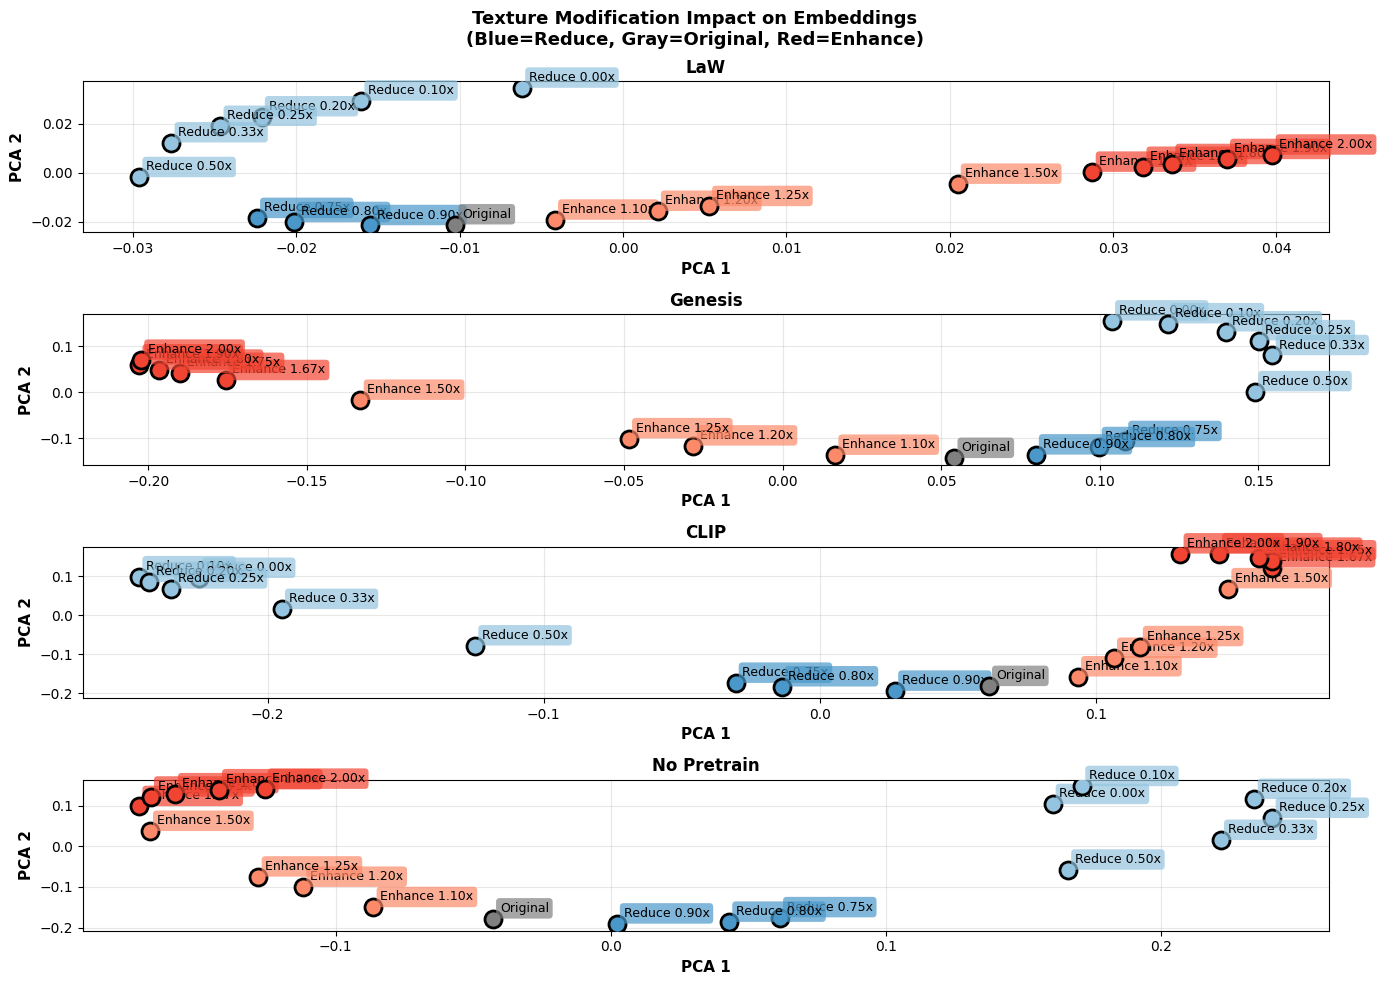

In [49]:
# Visualize: Texture Variants with Color-Coded Points

plot_texture_variant_embeddings(texture_variant_results, figsize=(14, 10))


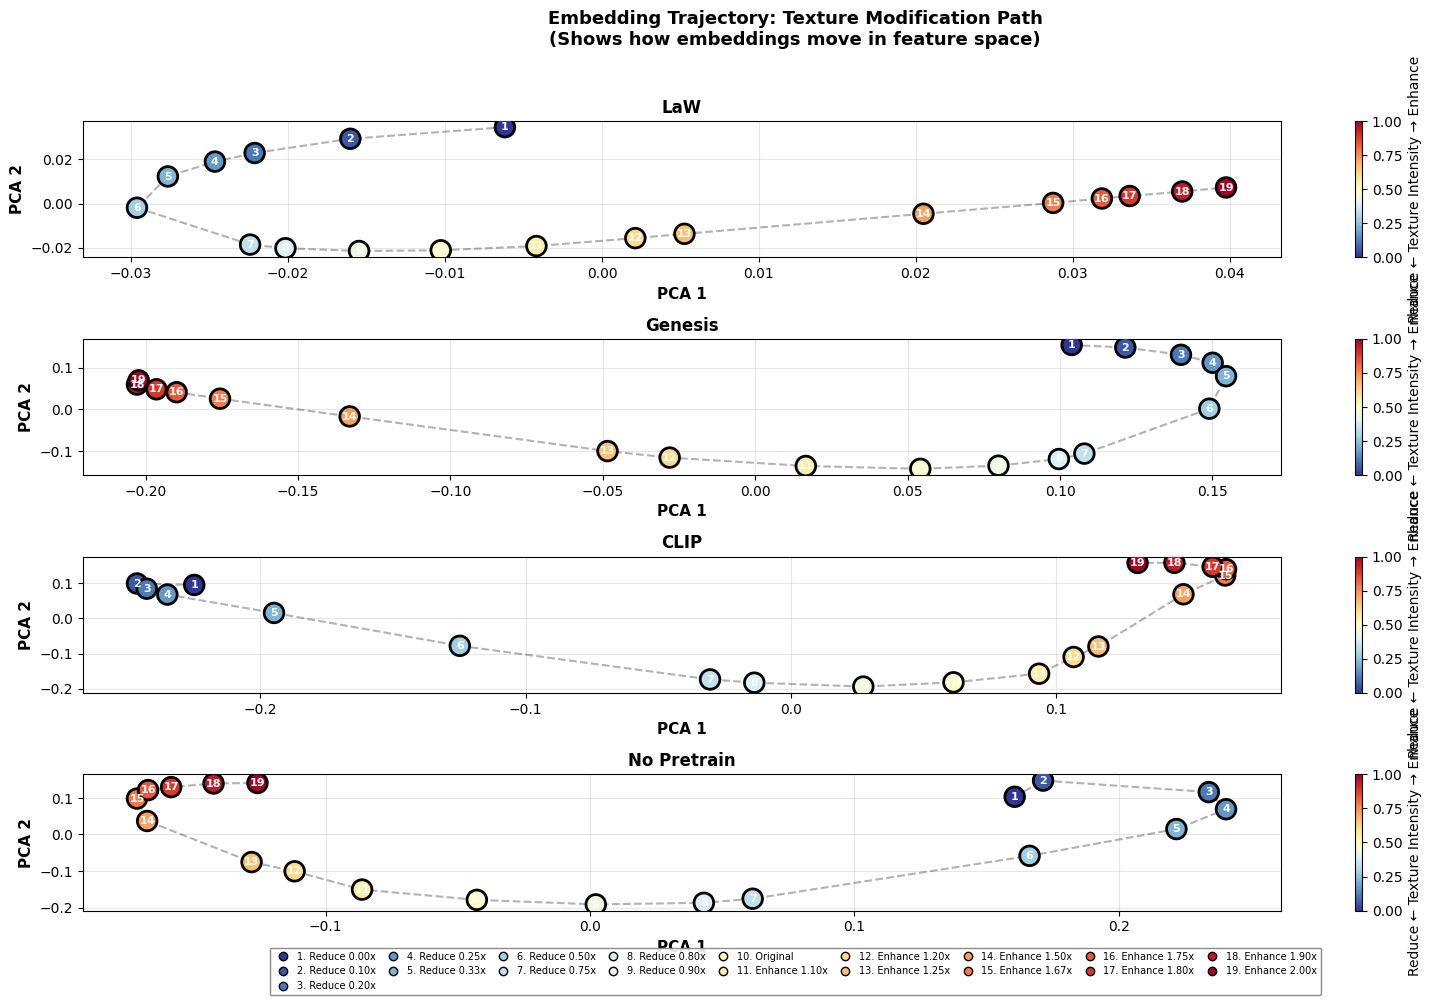

In [50]:
# Visualize: Embedding Trajectory (with connecting lines)

plot_texture_variant_trajectories(texture_variant_results, figsize=(16, 10))


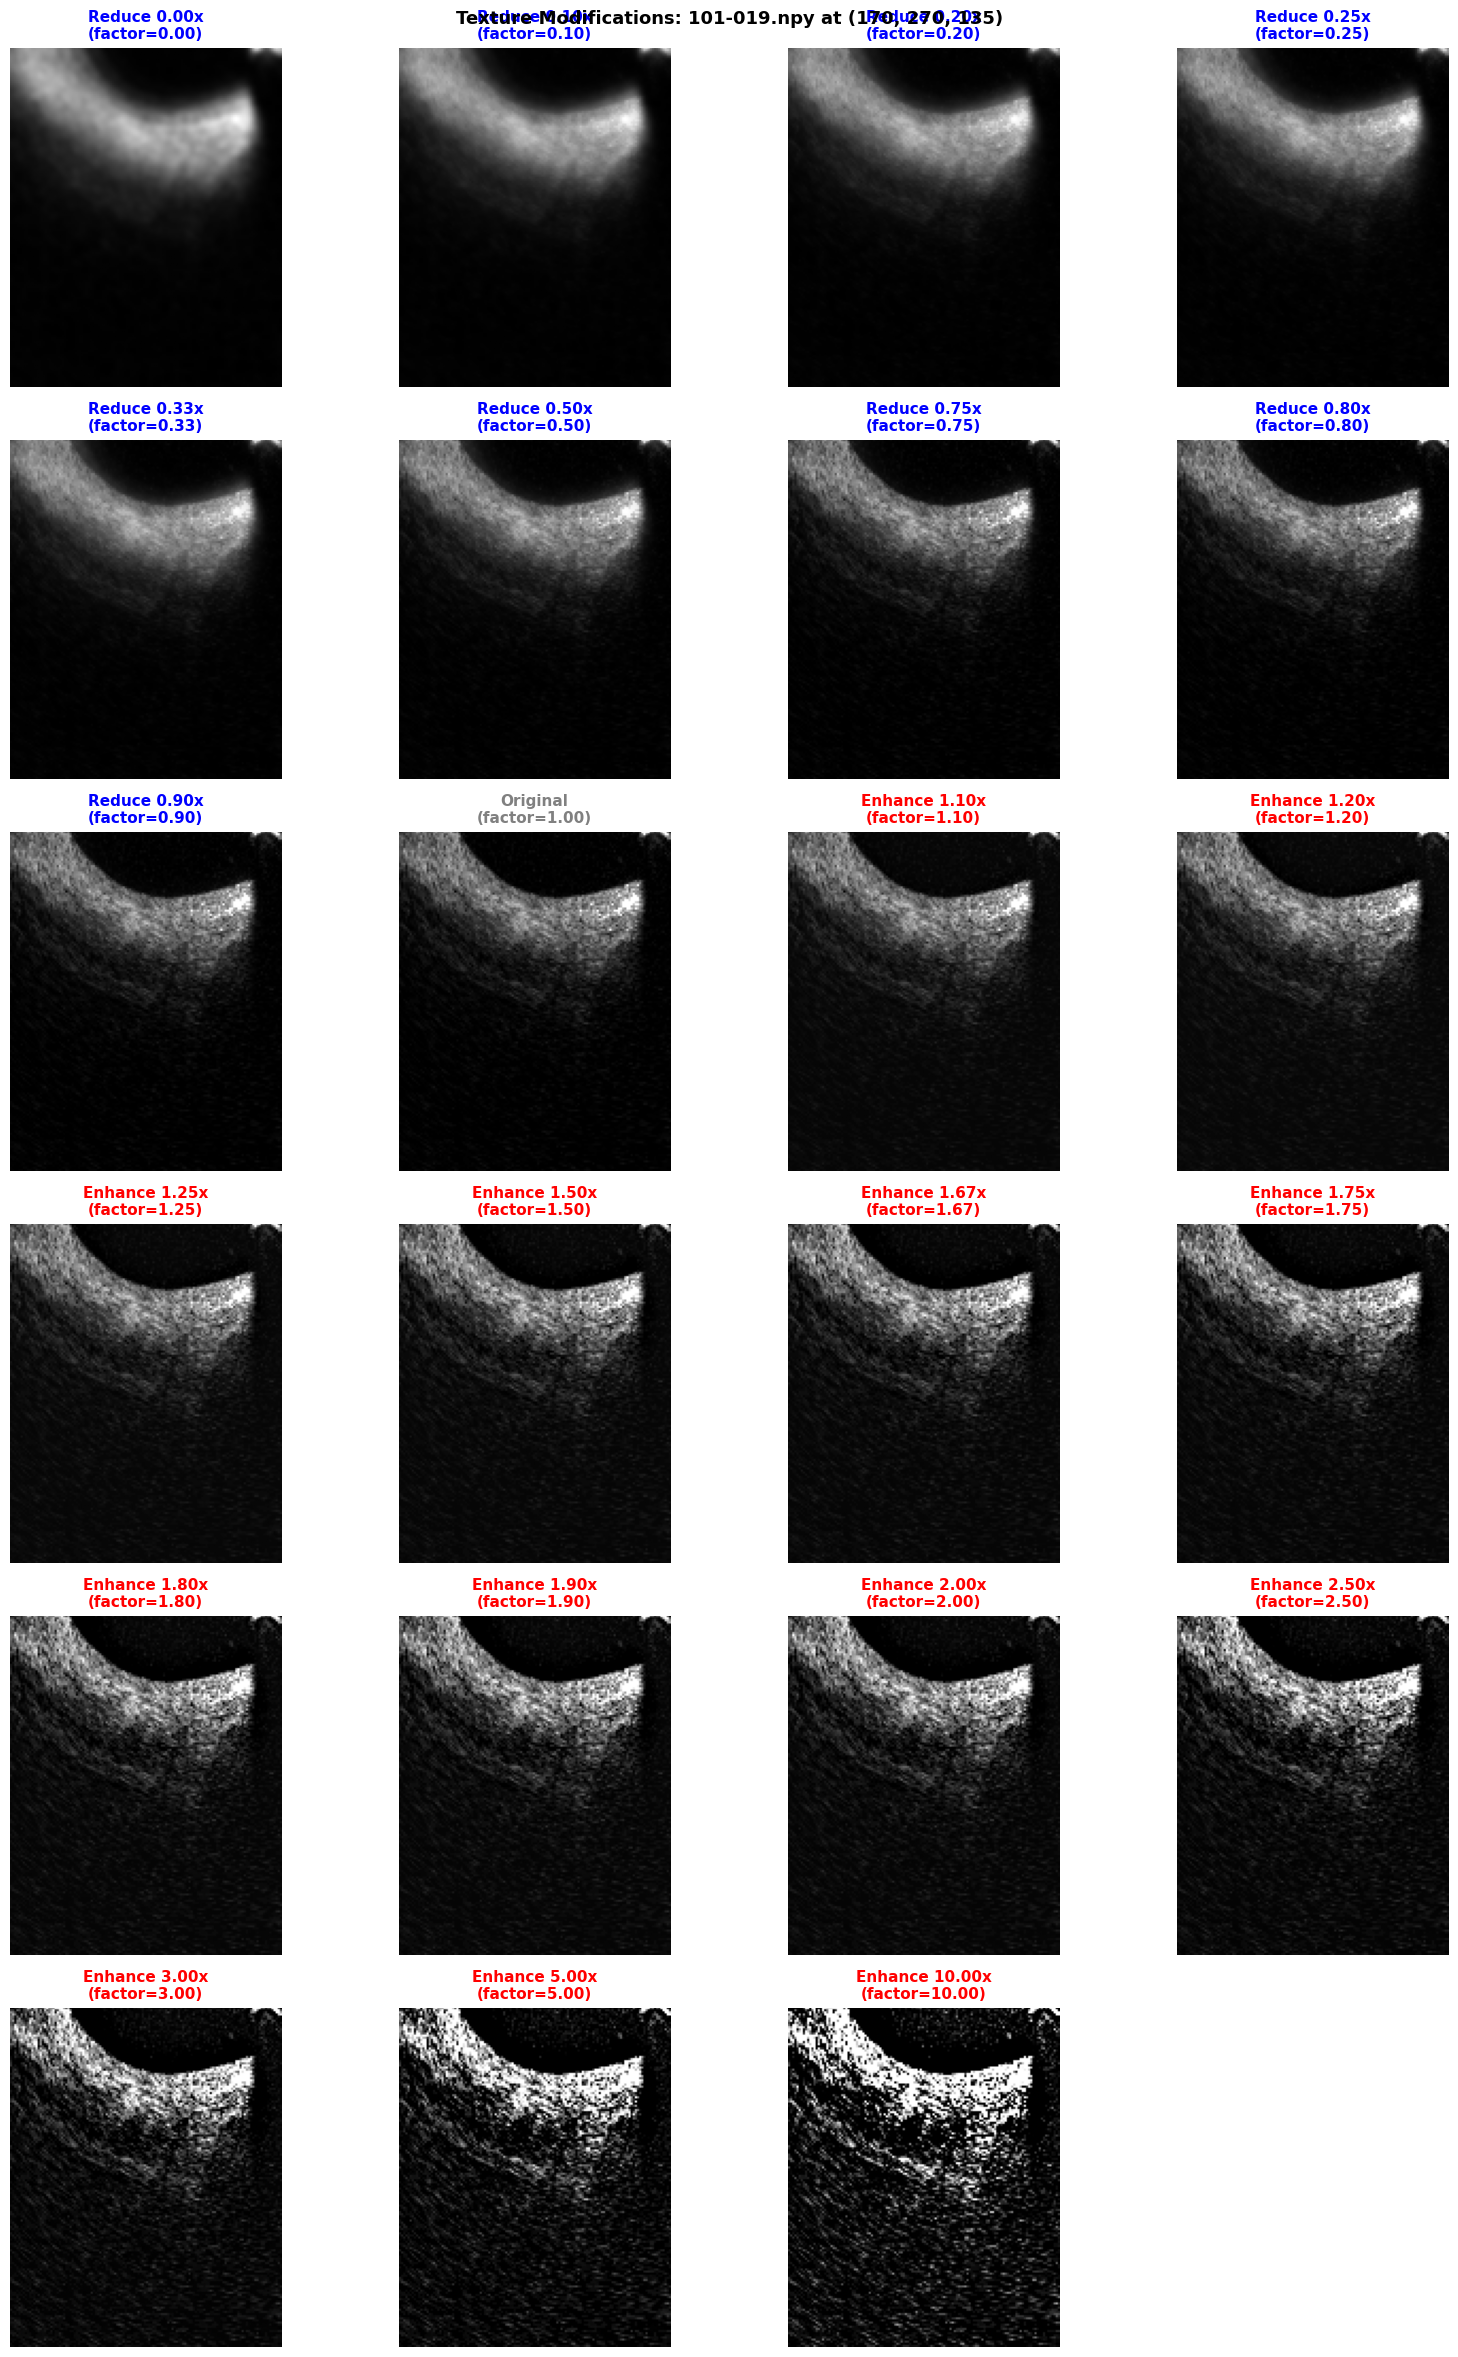

In [35]:
# Visualize: Texture-Modified Patches Side-by-Side

# Regenerate variants for visualization
variants = create_texture_modified_patches(single_patch, enhancement_factors=custom_factors)
mid_idx = DEFAULT_PATCH_SIZE[0] // 2

n_variants = len(variants['patches'])
n_cols = min(4, n_variants)
n_rows = (n_variants + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Color for each variant (matching the embedding plot)
colors_grid = []
for factor in variants['factors']:
    if factor < 1.0:
        colors_grid.append('blue')
    elif factor == 1.0:
        colors_grid.append('gray')
    else:
        colors_grid.append('red')

for i, (patch_variant, label, factor, col) in enumerate(zip(variants['patches'], 
                                                              variants['labels'], 
                                                              variants['factors'],
                                                              colors_grid)):
    ax = axes[i]
    slice_data = patch_variant[0, mid_idx]
    ax.imshow(slice_data, cmap='gray')
    ax.set_title(f'{label}\n(factor={factor:.2f})', fontsize=11, fontweight='bold', color=col)
    ax.axis('off')
    
    # Add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(col)
        spine.set_linewidth(3)
        spine.set_visible(True)

# Hide unused subplots
for i in range(n_variants, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f'Texture Modifications: {case_name} at {offset}', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
